In [191]:
import sys
import time
import common
import argparse
import datasets
import numpy as np
import pandas as pd
from pyDOE import lhs
from tqdm.notebook import tqdm, trange
from matplotlib import pyplot as plt
import estimators as estimators_lib
import tensorflow as tf
import tensorflow_lattice as tfl
%matplotlib inline
%config InlineBackend.figure_format='retina'


def Oracle(table, query):
    cols, idxs, ops, vals = query
    oracle_est = estimators_lib.Oracle(table)
    return oracle_est.Query(cols, ops, vals)


def cal_true_card(query, table):
    cols, idxs, ops, vals = query
    ops = np.array(ops)
    probs = Oracle(table, (cols, idxs, ops, vals))
    return probs


def GenerateQuery(table, min_num_filters, max_num_filters, rng, dataset, unique_values, latin_sample):
    """Generate a random query."""
    num_filters = rng.randint(max_num_filters - 1, max_num_filters)
    cols, idxs, ops, vals = SampleTupleThenRandom(table, num_filters, rng, dataset, unique_values, latin_sample)
    sel = cal_true_card((cols, idxs, ops, vals), table)# / float(table.cardinality)
    return cols, idxs, ops, vals, sel


def SampleTupleThenRandom(table, num_filters, rng, dataset, unique_values, latin_sample):
    idxs = rng.choice(len(table.columns), replace=False, size=num_filters)
    cols = np.take(table.columns, idxs)
    # If dom size >= 10, okay to place a range filter.
    # Otherwise, low domain size columns should be queried with equality.
    #ops = rng.choice(['='], size=num_filters)
    #ops = rng.choice(['<=', '>=', '>', '<'], size=num_filters)
    #ops = rng.choice(['<=', '>='], size=num_filters)
    ops = rng.choice(['<='], size=num_filters)
    #ops_all_eqs = ['='] * num_filters
    #sensible_to_do_range = [c.DistributionSize() >= 10 for c in cols]
    #ops = np.where(sensible_to_do_range, ops, ops_all_eqs)
    # if num_filters == len(table.columns):
    #     return table.columns,np.arange(len(table.columns)), ops, vals
    if latin_sample:
        vals = [np.random.choice(unique_values[i], size=1)[0] for i in idxs]
    else:
        vals = []
        new_table = table.data
        s = new_table.iloc[rng.randint(0, new_table.shape[0])]
        vals = s.values
        vals = vals[idxs]
    op_a = []
    val_a = []
    for i in range(len(vals)):
        val_a.append([vals[i]])
        op_a.append([ops[i]])
    return cols, idxs, pd.DataFrame(op_a).values, pd.DataFrame(val_a).values


def dictionary_column_interval(query_set):
    # Traverse all queries to apply the intervalization skill for each column
    column_interval = {}
    for i in range(n_column):
        column_interval[i] = set()
    for query in query_set:
        _, col_idxs, _, vals, _ = query
        for i in range(len(col_idxs)):
            column_interval[col_idxs[i]].add(vals[i][0])
    for k, v in column_interval.items():
        column_interval[k] = sorted(list(v))
        least, great = column_interval[k][0], column_interval[k][-1]
        column_interval[k] = sorted([0, least/2] + column_interval[k] + [great+1])
    return column_interval


def count_column_unique_interval(unique_intervals):
    # count unique query interval in each column
    return [len(v) for v in unique_intervals.values()]


def process_train_data(unique_intervals, query_set, train_size=1):
    train_size = 1
    X, Y = [], []
    origin = np.array([[0, v[-1]] for v in unique_intervals.values()]).ravel()
    for query in query_set:
        x = list(origin)
        _, col_idxs, ops, vals, sel = query
        for i in range(len(col_idxs)):
            if ops[i][0] == "<=":
                x[col_idxs[i]*2+1] = vals[i][0]
            elif ops[i][0] == "<":
                ind = unique_intervals[col_idxs[i]].index(vals[i][0]) - 1
                x[col_idxs[i]*2+1] = unique_intervals[col_idxs[i]][ind]
            elif ops[i][0] == ">":
                x[col_idxs[i]*2] = vals[i][0]
            elif ops[i][0] == ">=":
                ind = unique_intervals[col_idxs[i]].index(vals[i][0]) + 1
                x[col_idxs[i]*2] = unique_intervals[col_idxs[i]][ind]
            elif ops[i][0] == "=":
                ind = unique_intervals[col_idxs[i]].index(vals[i][0]) - 1
                x[col_idxs[i]*2] = unique_intervals[col_idxs[i]][ind]
                x[col_idxs[i]*2+1] = vals[i][0]
        X.append(x)
        Y.append(sel)
    X = np.array(X).astype(np.float32)
    Y = np.array(Y).astype(np.float32).reshape(-1, 1)
    total = np.concatenate((X, Y), axis=1)
    total = np.unique(total, axis=0)
    df_train = pd.DataFrame(total, columns=[f'col_{i}' for i in range(total.shape[1])])
    
    # boundary
    # df_train.loc[len(df_train.index)] = [0] * total.shape[1]
    # zero = [[v[-1], 0] for v in unique_intervals.values()]
    # df_train.loc[len(df_train.index)] = list(np.array(zero).ravel()) + [0.0]
    # one = [[0, v[-1]] for v in unique_intervals.values()]
    # df_train.loc[len(df_train.index)] = list(np.array(one).ravel()) + [1.0]
    
    new_train = np.array(df_train.sort_values(by=list(df_train.columns)[:-1]))
    sort_train_X, sort_train_Y = np.hsplit(new_train, [-1])

    shuffle = new_train.copy()
    np.random.shuffle(shuffle)
    train_X, train_Y = np.hsplit(shuffle, [-1])

    return train_X, train_Y, sort_train_X, sort_train_Y


def generate_data_new(grid, newpred):
    # delete all the zero cardinality rows
    line = pd.DataFrame(
        np.concatenate([grid, newpred], axis=1),
        columns=[f'col_{i}' for i in range(n_column)]+['card']
    )
    nozero = (line == 0).sum(axis=1)
    line = line[nozero==0].reset_index(drop=True)
    grid, pred = np.hsplit(np.array(line), [-1])
    pred = pred.astype(np.int32)
    # generate dataNew
    dataNew = pd.DataFrame(
        columns=[f'col_{i}' for i in range(n_column)],
        #index=range(n_row)
    )
    count = 0
    for i in trange(grid.shape[0]):
        df = dataNew
        grid_value = grid[i]
        for j in range(n_column):
            df = df.query(f'col_{j} <= {grid_value[j]}')
        card = pred[i][0] - df.shape[0]
        if card > 0:
            df3 = pd.DataFrame({f"col_{k}": [grid_value[k]] * card for k in range(n_column)})
            dataNew = dataNew.append(df3, ignore_index = True)
            #dataNew.iloc[count:count + card, :] = grid_value
            #count += card
            #if count > n_row:
                #print("Reached table length in ", i, grid.shape[0])
                #break
    #dataNew.dropna(axis=0, how='all', inplace=True)
    return dataNew
    
    
def execute_query(dataNew, query_set):
    diff = []
    for query in tqdm(query_set):
        df = dataNew
        _, col_idxs, ops, vals, sel = query
        for i in range(len(col_idxs)):
            op = '==' if ops[i][0] == "=" else ops[i][0]
            df = df.query(f'col_{col_idxs[i]} {op} {vals[i][0]}')
        card = 1 if round(sel * n_row) == 0 else round(sel * n_row)
        card2 = 1 if df.shape[0] == 0 else df.shape[0]
        diff.append(max(card/card2, card2/card))
    return diff


def print_error(diff, args):
    print(
        f"\n\n Q-error of Lattice (query size={args.query_size}, condition={args.num_conditions}, epoches={args.epochs}):\n"
    )
    print(f"min:    {np.min(diff)}")
    print(f"10:     {np.percentile(diff, 10)}")
    print(f"20:     {np.percentile(diff, 20)}")
    print(f"30:     {np.percentile(diff, 30)}")
    print(f"40:     {np.percentile(diff, 40)}")
    print(f"median: {np.median(diff)}")
    print(f"60:     {np.percentile(diff, 60)}")
    print(f"70:     {np.percentile(diff, 70)}")
    print(f"80:     {np.percentile(diff, 80)}")
    print(f"90:     {np.percentile(diff, 90)}")
    print(f"95:     {np.percentile(diff, 95)}")
    print(f"max:    {np.max(diff)}")
    print(f"mean:   {np.mean(diff)}")
    
    
def calc_time(tic, toc):
    total_time = toc - tic
    m, s = divmod(total_time, 60)
    h, m = divmod(m, 60)
    return f"{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}"

In [192]:
class LatticeCopulaModel(tf.keras.Model):
    def __init__(self, modelpath, dim, lattice_size, pwl_keypoints):
        super().__init__()
        self.dim = dim
        self.model_path = modelpath
        self.pwl_calibration_input_keypoints = pwl_keypoints
        #self.copula = CopulaLayer(dim=dim, lattice_size=lattice_size)
        
        self.cdf_inputs = []
        for i in range(self.dim):
            self.cdf_inputs.append(
                tf.keras.layers.Input(shape=[1], name='col_%s_inf' % i))
            self.cdf_inputs.append(
                tf.keras.layers.Input(shape=[1], name='col_%s_sup' % i))

        self.pwl1 = []
        for i in range(self.dim):
            self.pwl1.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.array(self.pwl_calibration_input_keypoints[i]),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    monotonicity='decreasing',
                    name='col_%s_inf_pwl1' % i
                )(self.cdf_inputs[2*i]))
            self.pwl1.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.array(self.pwl_calibration_input_keypoints[i]),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    monotonicity='increasing',
                    name='col_%s_sup_pwl1' % i
                )(self.cdf_inputs[2*i+1]))

        self.pwl2 = []
        for i in range(self.dim):
            self.pwl2.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.linspace(0, 1, num=400),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    monotonicity='decreasing',
                    name='col_%s_inf_pwl2' % i
                )(self.pwl1[2*i]))
            self.pwl2.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.linspace(0, 1, num=400),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    monotonicity='increasing',
                    name='col_%s_sup_pwl2' % i
                )(self.pwl1[2*i+1]))
            
            
        self.pwl3 = []
        for i in range(self.dim):
            self.pwl3.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.linspace(0, 1, num=400),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    monotonicity='decreasing',
                    name='col_%s_inf_pwl3' % i
                )(self.pwl2[2*i]))
            self.pwl3.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.linspace(0, 1, num=400),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    monotonicity='increasing',
                    name='col_%s_sup_pwl3' % i
                )(self.pwl2[2*i+1]))
            
            
            
#         self.lattice_cdf = []
#         for i in range(self.dim):
#             self.lattice_cdf.append(
#                 tfl.layers.Lattice(
#                     lattice_sizes=[lattice_size] * 2,
#                     interpolation='simplex',  # simplex
#                     monotonicities=['increasing'] * 2,
#                     output_min= 0.0,
#                     output_max= 1.0,
#                     name='lattice_col_%s' % i,
#                 )([self.pwl3[2*i], self.pwl3[2*i+1]]))
            
            
        
#         self.copula_lattice = tfl.layers.Lattice(
#             lattice_sizes=[lattice_size] * self.dim,
#             interpolation='hypercube',  # simplex， hypercube
#             monotonicities=['increasing'] * self.dim,
#             output_min= 0.0,
#             output_max= 1.0,
#             name='lattice',
#         )
            
        self.pwl = [self.pwl3[2*i+1] for i in range(self.dim)]

            
        self.model = tf.keras.models.Model(
            inputs=self.cdf_inputs,
            outputs= self.pwl#self.copula_lattice(self.lattice_cdf)
        )
       
        self.model.summary()
    

    def call(self, inputs, training=True):
        x = self.model(inputs)
#         x_reshape = tf.keras.layers.concatenate(x) if self.dim > 1 else x
#         y = self.copula(x_reshape)
#         grad = y
#         for i in range(self.dim):
#             grad = tf.gradients(grad, x[i])
#             grad = grad[0]
#         return y, x, grad
        return x
        

#     def compile(self, loss, optimizer):
#         super().compile()
#         self.loss = loss
#         self.optimizer = optimizer


#     def train_step(self, data, training=True):
#         x, y = data
#         with tf.GradientTape() as tape:
#             y_pred = self(x)
#             loss = tf.reshape(self.loss(y, y_pred), [-1, 1])
# #             loss2 = tf.nn.relu(y_pred - tf.keras.backend.min(lattice_inputs))
# #             lb = tf.math.maximum(sum(lattice_inputs) - self.dim + 1, 0)
# #             loss3 = tf.nn.relu(lb - y_pred)
# #             loss4 = tf.nn.relu(-lattice_grad)
# #             loss = tf.reduce_sum(loss1 + loss2 + loss3 + loss4)
#             #loss = tf.reduce_sum(loss1)
#         trainable_vars = self.trainable_weights
#         grads = tape.gradient(loss, trainable_vars)
#         self.optimizer.apply_gradients(zip(grads, trainable_vars))
#         return {"loss": loss}

In [193]:
class Trainer:
    def __init__(self, name, dim, lattice_size, pwl_keypoints=None):
        self.dim = dim
        self.model_path = './models/Lattice/model/' + name
        self.weight_path = './models/Lattice/weight/' + name
        self.pwl_keypoints = unique_intervals if pwl_keypoints is None else pwl_keypoints
        self.model = LatticeCopulaModel(modelpath=self.model_path, dim=dim, lattice_size=lattice_size, pwl_keypoints=self.pwl_keypoints)
        # self.model.build(input_shape=[(None, 1) for i in range(2*self.dim)])
        # self.model.summary()
        
    def train(self, X, y, lr, bs, epochs,
              reduceLR_factor,
              reduceLR_patience,
              earlyStopping_patience,
              loss='MSE',
              opt='Adam',
              verbose=1):
        assert X.shape[0] == y.shape[0]

        X = X.astype(np.float32)
        y = y.astype(np.float32)

        features = [X[:, i] for i in range(X.shape[1])]
        target = y
        Loss = {
            'MAE': tf.keras.losses.mean_absolute_error,
            'MSE': tf.keras.losses.mean_squared_error,
            'MAPE': tf.keras.losses.mean_absolute_percentage_error
        }

        Opt = {
            'Adam': tf.keras.optimizers.Adam(),
            'Nadam': tf.keras.optimizers.Nadam(),
            'Adagrad': tf.keras.optimizers.Adagrad(),
            'Adadelta': tf.keras.optimizers.Adadelta(),
            'Adamax': tf.keras.optimizers.Adamax(),
            'RMSprop': tf.keras.optimizers.RMSprop(),
        }
        self.model.compile(loss=Loss[loss], optimizer=Opt[opt])

        #self.model.save('%s' % self.model_path, save_format='tf')
        
        

        earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                         patience=earlyStopping_patience,
                                                         verbose=verbose,
                                                         min_delta=1e-20,
                                                         restore_best_weights=True,
                                                         mode='min')
        mcp_save = tf.keras.callbacks.ModelCheckpoint('%s.hdf5' %
                                                      self.weight_path,
                                                      save_best_only=True,
                                                      monitor='loss',
                                                      mode='min',
                                                      save_weights_only=True)
        reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=reduceLR_factor,
            patience=reduceLR_patience,
            verbose=verbose,
            min_delta=1e-20,
            mode='min')

        self.model.fit(features,
                       target,
                       epochs=epochs,
                       batch_size=bs,
                       verbose=1,
                       callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
                       )
        # self.model.build(input_shape = (None, self.dim*2))
        # self.model.load_weights('%s.hdf5' % self.weight_path, custom_objects={"Model": Model})

        
    def inference(self, grid):
        assert grid.shape[1] == self.dim * 2
        pred = self.model.predict(np.hsplit(grid, self.dim * 2))
        return pred

In [194]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataset', type=str, default='test_neural', help='Dataset.')
    parser.add_argument('--latin-query', type=bool, default=True, help='latin sample of query')
    parser.add_argument('--query-size', type=int, default=10000, help='query size')
    parser.add_argument('--num-conditions', type=int, default=2, help='num of conditions')
    parser.add_argument('--epochs', type=int, default=5000, help='Number of epochs to train for.')
    parser.add_argument('--bs', type=int, default=1000, help='Batch size.')
    parser.add_argument('--lhs-n', type=int, default=10000, help='Number of lhs samples to generate for.')
    parser.add_argument('--train-size', type=float, default=0.8, help='train size')
    parser.add_argument('--lr', type=float, default=1e-2, help='learning rate')
    parser.add_argument('--reduceLR_factor', type=float, default=0.5, help='reduceLR_factor')
    parser.add_argument('--reduceLR_patience', type=int, default=50, help='reduceLR_patience')
    parser.add_argument('--earlyStopping_patience', type=int, default=500, help='earlyStopping_patience')
    parser.add_argument('--loss', type=str, default='MSE', help='Loss.')
    parser.add_argument('--opt', type=str, default='Adam', help='Optimizer.')
    parser.add_argument('--lattice-size', type=int, default=2, help='Lattice size.')
    parser.add_argument('--seed', type=int, default=4321, help='Random seed')
    #args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    rng = np.random.RandomState(args.seed)
    
    table = datasets.LoadDataset(args.dataset + '.csv', args.dataset, type_casts={})
    table_size = table.data.shape
    n_row, n_column = table_size[0], table_size[1]
    # unique values
    read_data = pd.read_csv('./datasets/' + args.dataset + '.csv', header=None)
    read_data.columns = [f"col_{i}" for i in range(n_column)]
    unique_values = dict()
    for i in range(n_column):
        unique_values[i] = sorted(read_data[f"col_{i}"].unique())
    

    print('Generating Queries ...')
    time0 = time.time()
    query_set = [
        GenerateQuery(table, 1, args.num_conditions + 1, rng, args.dataset, unique_values, args.latin_query)
        for i in trange(args.query_size)
    ]

    
    print("\n\nProcessing data...")
    time1 = time.time()
    unique_intervals = dictionary_column_interval(query_set)
    column_interval_number = count_column_unique_interval(unique_intervals)
    print("\n Column intervals:", column_interval_number, np.product(column_interval_number))
    train_X, train_Y, sort_train_X, sort_train_Y = process_train_data(unique_intervals, query_set)
    

load dataset test_neural.csv done
(846, 2)
(846, 2)
0
1
0 681
1 684
Generating Queries ...





Processing data...

 Column intervals: [684, 687] 469908


In [198]:
pred

array([[  1.],
       [  1.],
       [  1.],
       ...,
       [697.],
       [827.],
       [830.]], dtype=float32)

In [205]:
grid

array([[3.38302198e-04, 6.18172297e-03],
       [3.38302198e-04, 1.01782635e-01],
       [3.38302198e-04, 1.98964924e-01],
       ...,
       [9.84663963e-01, 6.94077075e-01],
       [9.84663963e-01, 8.86716485e-01],
       [9.84663963e-01, 8.92466962e-01]], dtype=float32)

In [196]:
grid = sort_train_X[:, [1, 3]]
pred = sort_train_Y
#newpred = np.round(pred * n_row)  # newpred is the predict cardinality
newpred = pred
print("\nBegin generating table...")
dataNew = generate_data_new(grid, newpred)

print("\nFinish generate table, calculating Q-error on new table...")
time4 = time.time()
diff = execute_query(dataNew, query_set)
print_error(diff, args)

print(f"\noriginal table shape: {table_size}")
print(f"  Our table shape   : {dataNew.shape}")


Begin generating table...




Finish generate table, calculating Q-error on new table...





 Q-error of Lattice (query size=10000, condition=2, epoches=5000):

min:    392.7857142857143
10:     712.017773931567
20:     745.5374999999999
30:     767.6666666666665
40:     788.7518796992481
median: 802.1333333333333
60:     812.542372881356
70:     822.7155963302753
80:     832.5714285714286
90:     842.9010989010989
95:     846.0
max:    3807.0
mean:   787.795155621272

original table shape: (846, 2)
  Our table shape   : (883, 2)


In [197]:
dataNew

,col_0,col_1
0,0.000338,0.006182
1,0.001128,0.049022
2,0.001128,0.049022
3,0.001579,0.025446
4,0.001579,0.025446
...,...,...
878,0.972936,0.872340
879,0.984664,0.603795
880,0.984664,0.603795
881,0.984664,0.603795


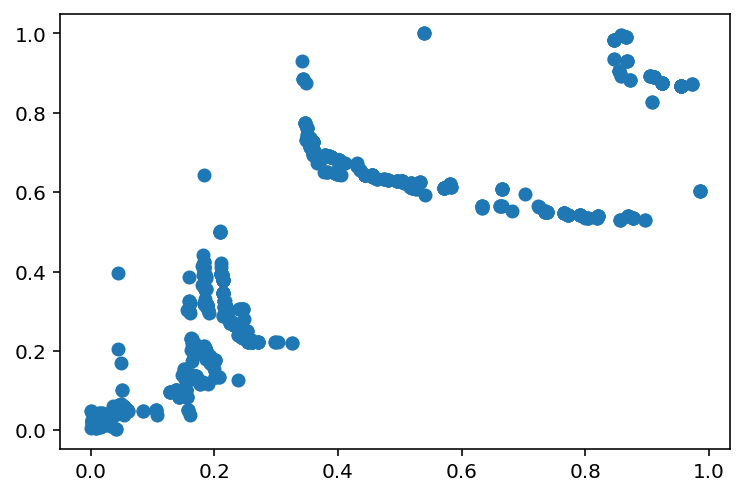

In [203]:
dd = np.array(dataNew)
plt.plot(dd[:,0], dd[:,1], 'o')

In [ ]:
lb = np.array([v[1] for v in unique_intervals.values()])
ub = np.array([v[-1] for v in unique_intervals.values()])
lhs_sample = lhs(n_column, samples=10000, criterion='center')
sample_df = pd.DataFrame(lb + (ub-lb)*lhs_sample, columns=[f'col_{i}' for i in range(n_column)])
grid = np.array(sample_df.sort_values(by=list(sample_df.columns)))

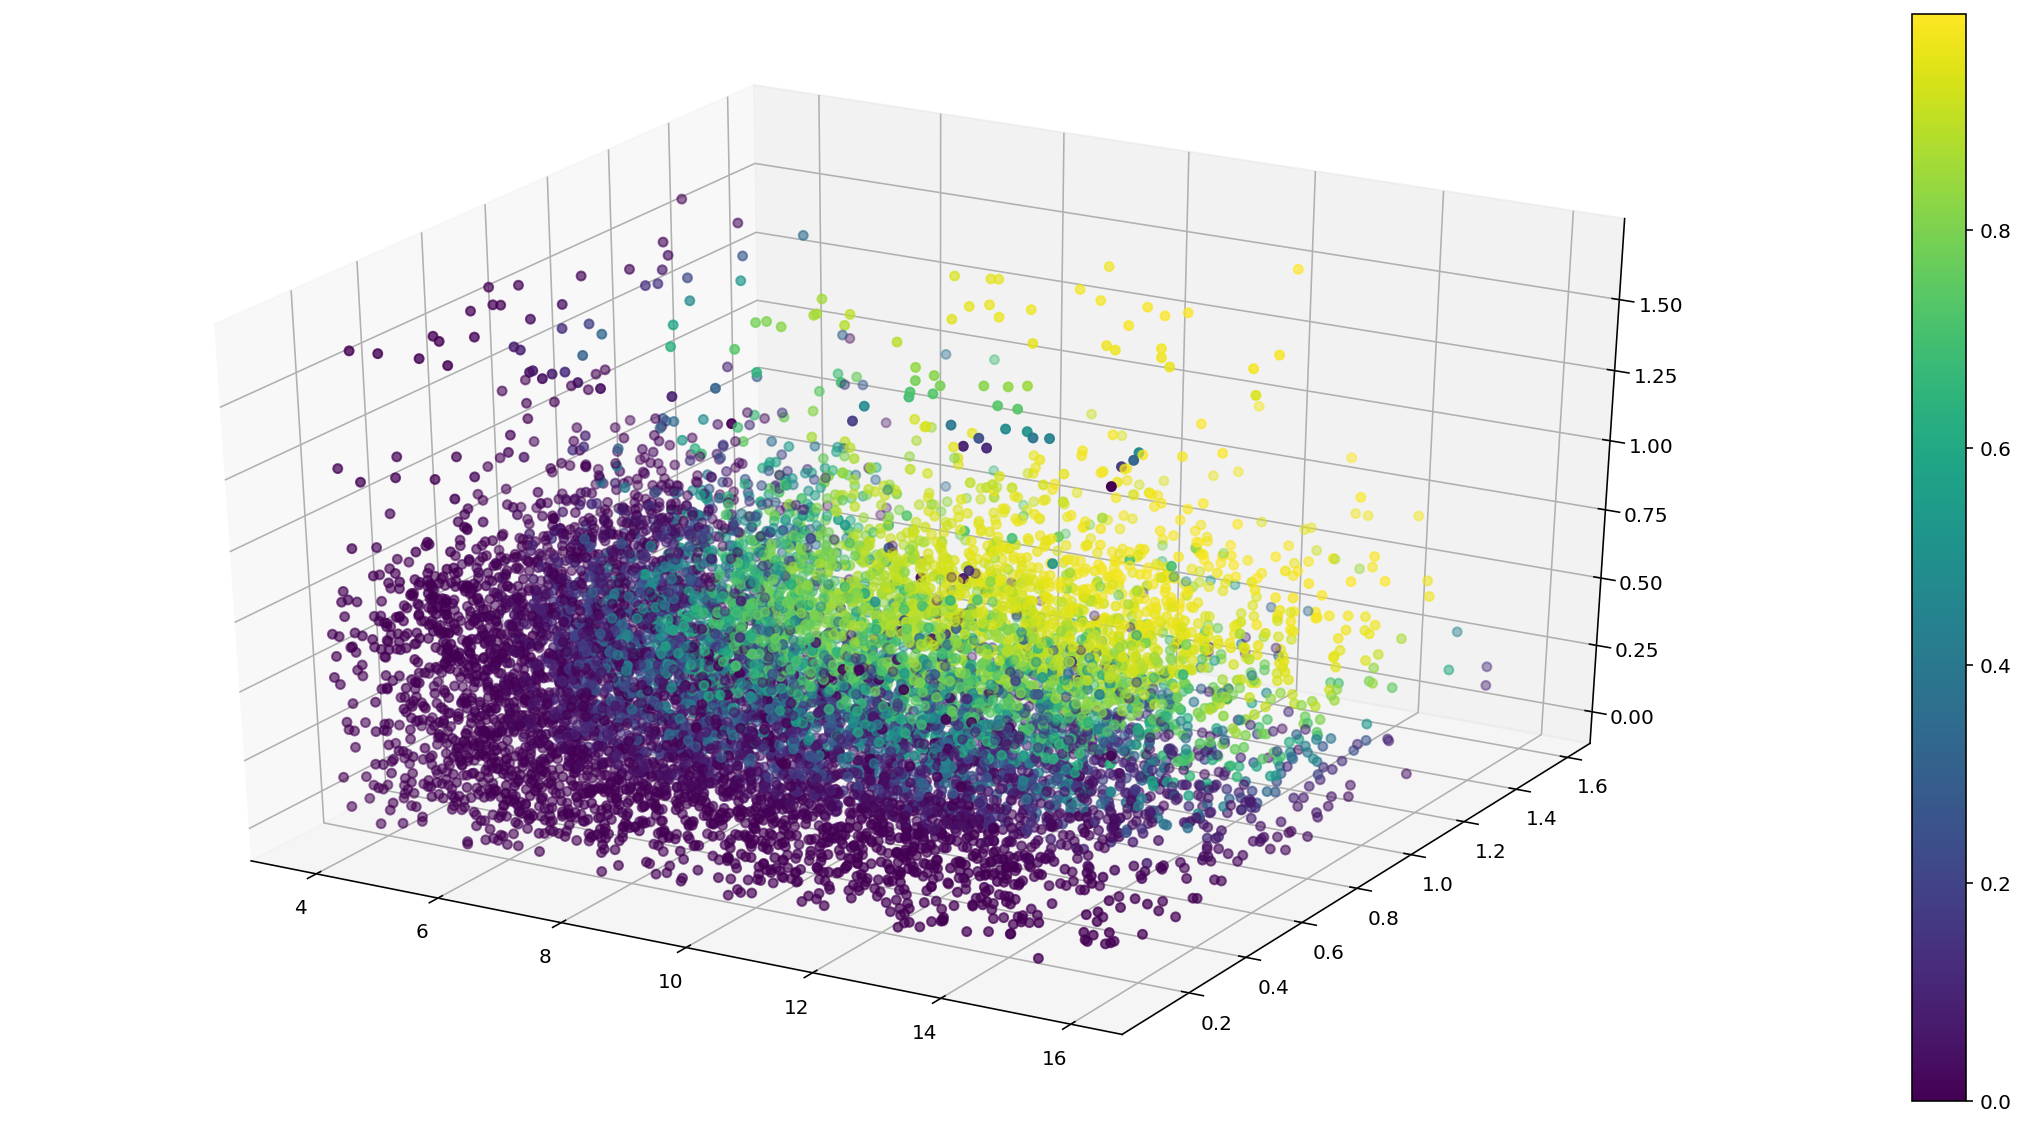

In [109]:
fig = plt.figure(figsize=(20, 10))
ax = fig.gca(projection='3d')
X = train_X[:, 1]
Y = train_X[:, 3]
Z = train_X[:, 5]
V = train_Y.ravel()
sc = ax.scatter(X, Y, Z, c=V)
plt.colorbar(sc)

In [131]:
data_x = pd.read_csv('../Neural-Copula/real_data/INTC.csv').iloc[:, 1]

In [132]:
data_x

0        7.171875
1        7.328125
2        7.343750
3        7.140625
4        7.265625
          ...    
1258    33.625000
1259    33.125000
1260    32.687500
1261    32.125000
1262    30.937500
Name: Open, Length: 1263, dtype: float64

In [135]:
data_x = pd.read_csv('../Neural-Copula/real_data/INTC.csv').iloc[:, 1]
data_y = pd.read_csv('../Neural-Copula/real_data/MSFT.csv').iloc[:, 1]
x = np.array(data_x).reshape(-1, 1)
y = np.array(data_y).reshape(-1, 1)
data = np.concatenate((x, y), axis=1)
print(data.shape)

(1263, 2)


In [137]:
from sklearn.model_selection import train_test_split

In [138]:
for i in range(data.shape[-1]):
    data[:,i] = (data[:,i]-np.min(data[:,i]))/(np.max(data[:,i]-np.min(data[:,i])))
X_train, X_test = train_test_split(data,test_size=0.33, random_state=42)

In [139]:
number_of_dimension = data.shape[1]
number_of_training_samples = X_train.shape[0]
number_of_testing_samples = X_test.shape[0]
data_domain = np.asarray([[np.min(X_train[:,i]),np.max(X_train[:,i])] for i in range(number_of_dimension)])
print('number_of_dimension:',number_of_dimension)
print('number_of_training_samples:',number_of_training_samples)
print('number_of_testing_samples:',number_of_testing_samples)
print('data_domain:\n',data_domain)

number_of_dimension: 2
number_of_training_samples: 846
number_of_testing_samples: 417
data_domain:
 [[3.3830221e-04 9.8466396e-01]
 [0.0000000e+00 1.0000000e+00]]


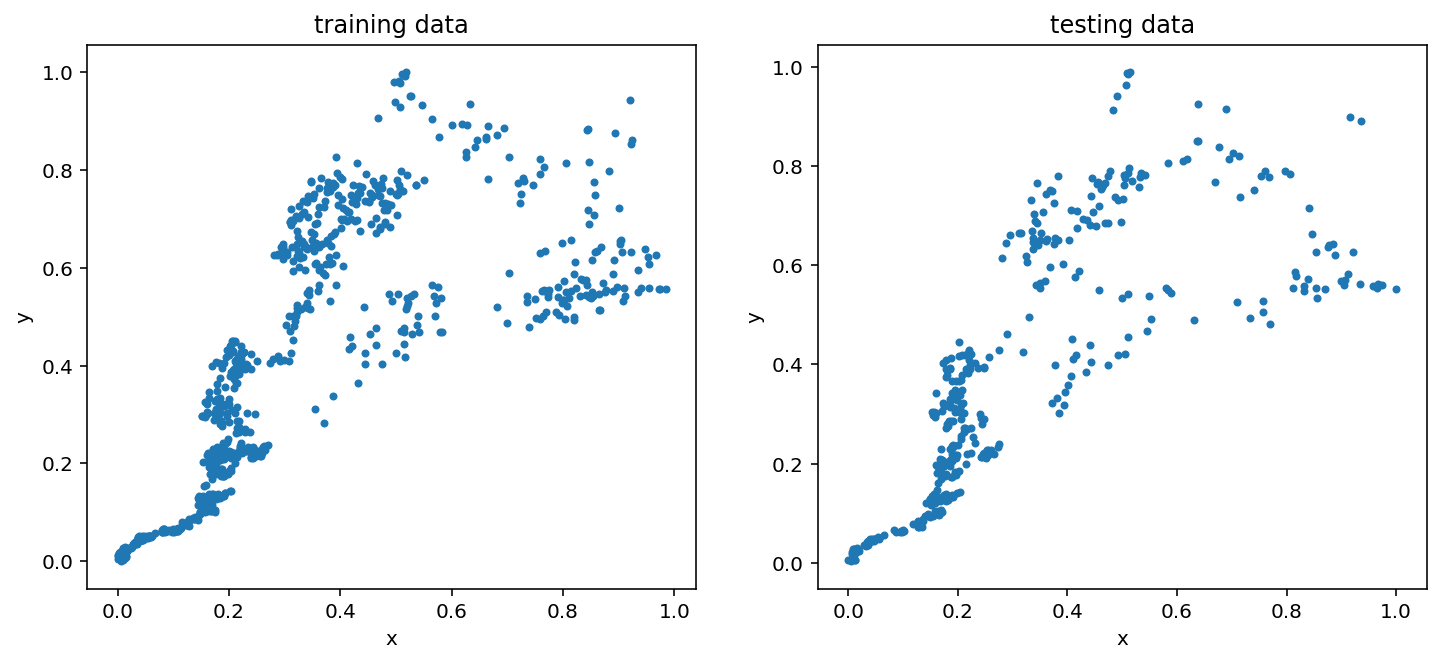

In [141]:
if number_of_dimension==2:
    fig, axs = plt.subplots(1,2,constrained_layout=False, figsize=(12, 5))
    #
    ax = axs.ravel()[0]
    ax.scatter(X_train[:,0], X_train[:,1], marker='.')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('training data')
    #
    ax = axs.ravel()[1]
    ax.scatter(X_test[:,0], X_test[:,1], marker='.')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('testing data')

In [143]:
df = pd.DataFrame(X_train)

In [146]:
df.to_csv("../LPALG/datasets/test_neural.csv", index=False, header=None)

In [164]:
dx = np.concatenate((sort_train_X[:681, 1:2], sort_train_Y[:681]), axis=1)

In [171]:
dx

array([[3.3830220e-04, 1.1820331e-03],
       [1.1276500e-03, 3.5460992e-03],
       [1.5787099e-03, 4.7281324e-03],
       ...,
       [9.7293639e-01, 9.9763596e-01],
       [9.7474062e-01, 9.9881798e-01],
       [9.8466396e-01, 1.0000000e+00]], dtype=float32)

In [169]:
dy = np.concatenate((sort_train_X[681:, 3:4], sort_train_Y[681:]), axis=1)

In [170]:
dy

array([[0.        , 0.00118203],
       [0.00345026, 0.00236407],
       [0.00488787, 0.0035461 ],
       ...,
       [0.9919494 , 0.99763596],
       [0.9971248 , 0.998818  ],
       [1.        , 1.        ]], dtype=float32)

In [177]:
dx

array([[3.3830220e-04, 1.1820331e-03],
       [1.1276500e-03, 3.5460992e-03],
       [1.5787099e-03, 4.7281324e-03],
       ...,
       [9.7293639e-01, 9.9763596e-01],
       [9.7474062e-01, 9.9881798e-01],
       [9.8466396e-01, 1.0000000e+00]], dtype=float32)

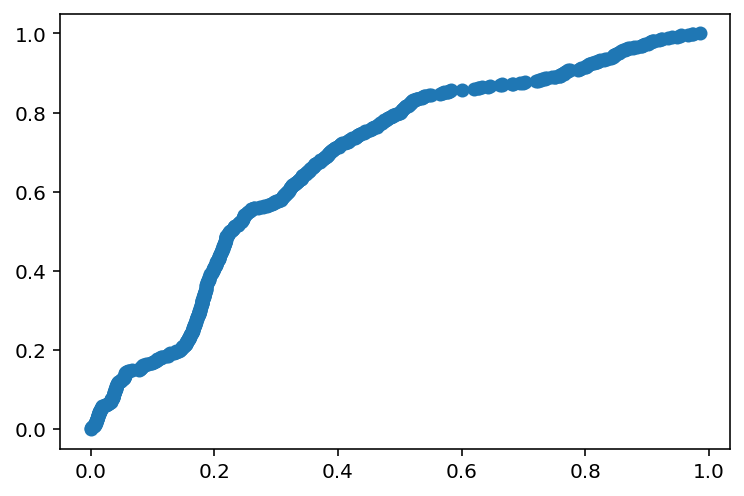

In [185]:
plt.plot(dx[:, 0], dx[:, 1], 'o')

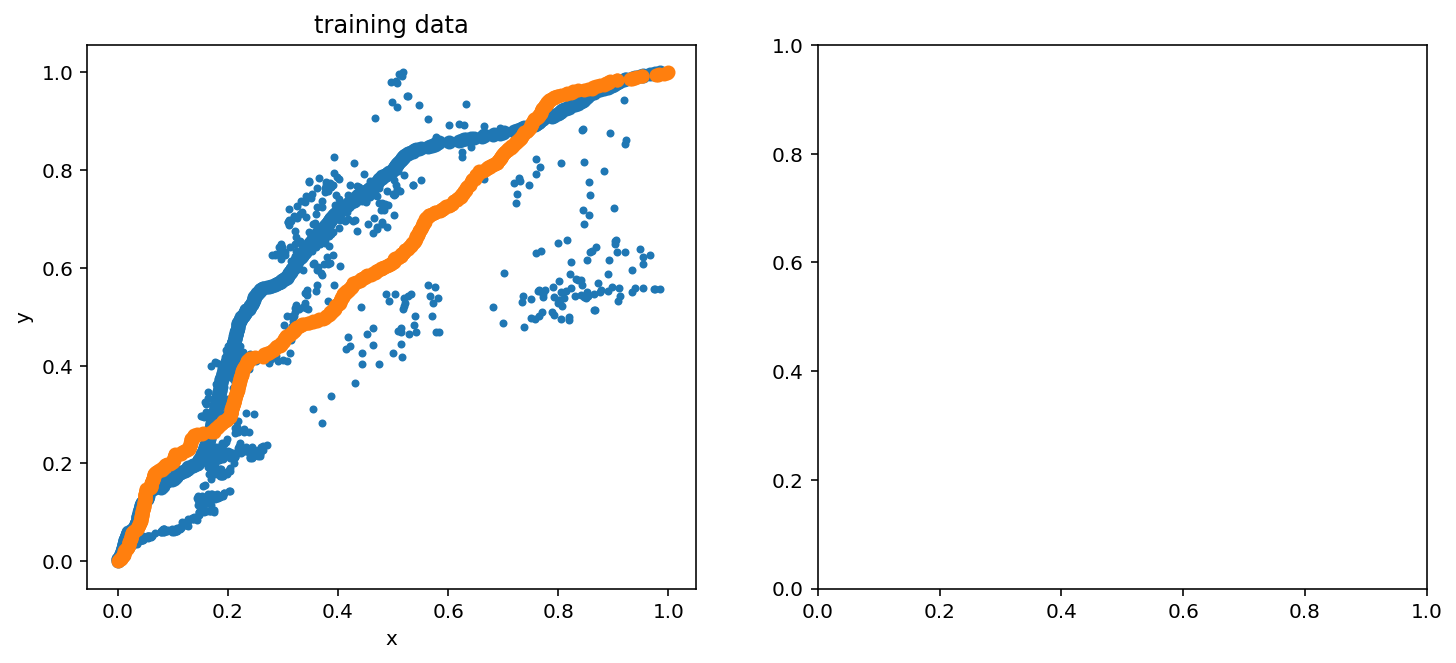

In [188]:
if number_of_dimension==2:
    fig, axs = plt.subplots(1,2,constrained_layout=False, figsize=(12, 5))
    #
    ax = axs.ravel()[0]
    ax.scatter(X_train[:,0], X_train[:,1], marker='.')
    ax.plot(dx[:, 0], dx[:, 1], 'o')
    ax.plot(dy[:, 0], dy[:, 1], 'o')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('training data')

In [74]:
    print("\n\nTraining...\n")
    time2 = time.time()
    name = f"{args.dataset}_{args.query_size}query_{args.num_conditions}column_{args.epochs}epoch"
    m = Trainer(name, n_column, args.lattice_size, pwl_keypoints=None)
    m.train(train_X, train_Y, args.lr, args.bs, args.epochs, args.reduceLR_factor, args.reduceLR_patience, args.earlyStopping_patience, loss=args.loss, opt=args.opt)

    
    print("\nGenerating dataNew")
    time3 = time.time()
    # Full-Factorial net of unique intervals
#     values = [v for v in unique_intervals.values()]
#     mesh = np.meshgrid(*values)
#     grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)
    
    # Latin Hypercube sampling
#     lb = np.array([v[1] for v in unique_intervals.values()])
#     ub = np.array([v[-1] for v in unique_intervals.values()])
#     lhs_sample = lhs(n_column, samples=10000, criterion='center')
#     sample_df = pd.DataFrame(lb + (ub-lb)*lhs_sample, columns=[f'col_{i}' for i in range(n_column)])
#     grid = np.array(sample_df.sort_values(by=list(sample_df.columns)))
    
    
    
    
#     lb = np.array([1] * n_column)
#     ub = np.array(column_interval_number) - 1
#     lhs_sample = lb + (ub - lb) * lhs(n_column, samples=args.lhs_n, criterion='center')
#     index = np.round(lhs_sample).astype(np.int32)
#     grid_mesh = np.empty_like(index, dtype=np.float32)
#     for i in range(args.lhs_n):
#         idx = index[i, :]
#         grid_mesh[i] = [unique_intervals[j][idx[j]] for j in range(n_column)]
#     sample_df = pd.DataFrame(grid_mesh, columns=[f'col_{i}' for i in range(n_column)])
#     grid_a = np.array(sample_df.sort_values(by=list(sample_df.columns)))
#     greatest = np.array([v[-1] for v in unique_intervals.values()]).reshape(1, -1)
#     grid = np.concatenate([grid_a, greatest], axis=0)
#     # transform 1-input grid to 2-input extend grid
#     assert grid.shape[1] == n_column
#     length = grid.shape[0]
#     inf = [0] * length
#     grid_dict = {}
#     for i in range(n_column):
#         grid_dict[f'col_{i}_inf'] = inf
#         grid_dict[f'col_{i}_sup'] = grid[:, i]
#     extend_grid = np.array(pd.DataFrame(grid_dict))
#     print("Begin model inference")
#     pred = m.inference(extend_grid)
#     print("Done")
    
#     pred = pred[0]
#     newpred = np.round(pred * n_row)  # newpred is the predict cardinality
#     print("\nBegin generating table...")
#     dataNew = generate_data_new(grid, newpred)

#     print("\nFinish generate table, calculating Q-error on new table...")
#     time4 = time.time()
#     diff = execute_query(dataNew, query_set)
#     print_error(diff, args)

#     print(f"\noriginal table shape: {table_size}")
#     print(f"  Our table shape   : {dataNew.shape}")
#     time5 = time.time()

#     print("\nTime passed:")
#     print(" Generate Query  :  ", calc_time(time0, time1))
#     print(" Build  Lattice  :  ", calc_time(time1, time2))
#     print("   Training      :  ", calc_time(time2, time3))
#     print("Generate New Data:  ", calc_time(time3, time4))
#     print("Calculate Q-error:  ", calc_time(time4, time5))

load dataset wine1.csv done
(6497, 1)
(6497, 1)
0
0 106
Generating Queries ...





Processing data...

 Column intervals: [109] 109


Training...

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
col_0_sup (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
col_0_sup_pwl1 (PWLCalibration) (None, 1)            109         col_0_sup[0][0]                  
__________________________________________________________________________________________________
col_0_sup_pwl2 (PWLCalibration) (None, 1)            400         col_0_sup_pwl1[0][0]             
__________________________________________________________________________________________________
col_0_inf (InputLayer)          [(None, 1)]          0                                            
_________________________

106/106 [==============================] - 0s 79us/sample - loss: 5.7801e-04
Epoch 78/5000
106/106 [==============================] - 0s 76us/sample - loss: 5.2244e-04
Epoch 79/5000
106/106 [==============================] - 0s 80us/sample - loss: 4.3307e-04
Epoch 80/5000
106/106 [==============================] - 0s 77us/sample - loss: 3.1302e-04
Epoch 81/5000
106/106 [==============================] - 0s 35us/sample - loss: 3.1954e-04
Epoch 82/5000
106/106 [==============================] - 0s 33us/sample - loss: 6.2625e-04
Epoch 83/5000
106/106 [==============================] - 0s 34us/sample - loss: 0.0012
Epoch 84/5000
106/106 [==============================] - 0s 34us/sample - loss: 0.0018
Epoch 85/5000
106/106 [==============================] - 0s 33us/sample - loss: 0.0025
Epoch 86/5000
106/106 [==============================] - 0s 32us/sample - loss: 0.0031
Epoch 87/5000
106/106 [==============================] - 0s 32us/sample - loss: 0.0035
Epoch 88/5000
106/106 [==========

106/106 [==============================] - 0s 32us/sample - loss: 5.0736e-05
Epoch 168/5000
106/106 [==============================] - 0s 31us/sample - loss: 5.1650e-05
Epoch 169/5000
106/106 [==============================] - 0s 30us/sample - loss: 4.6913e-05
Epoch 170/5000
106/106 [==============================] - 0s 32us/sample - loss: 3.6880e-05
Epoch 171/5000
106/106 [==============================] - 0s 30us/sample - loss: 2.9930e-05
Epoch 172/5000
106/106 [==============================] - 0s 75us/sample - loss: 2.3310e-05
Epoch 173/5000
106/106 [==============================] - 0s 76us/sample - loss: 1.7602e-05
Epoch 174/5000
106/106 [==============================] - 0s 79us/sample - loss: 1.7377e-05
Epoch 175/5000
106/106 [==============================] - 0s 32us/sample - loss: 1.9109e-05
Epoch 176/5000
106/106 [==============================] - 0s 31us/sample - loss: 2.1741e-05
Epoch 177/5000
106/106 [==============================] - 0s 30us/sample - loss: 2.6084e-05
Epo

Epoch 256/5000
106/106 [==============================] - 0s 34us/sample - loss: 2.8442e-04
Epoch 257/5000
106/106 [==============================] - 0s 30us/sample - loss: 3.2391e-04
Epoch 258/5000
106/106 [==============================] - 0s 33us/sample - loss: 3.3769e-04
Epoch 259/5000
106/106 [==============================] - 0s 30us/sample - loss: 3.2716e-04
Epoch 260/5000
106/106 [==============================] - 0s 31us/sample - loss: 2.9769e-04
Epoch 261/5000
106/106 [==============================] - 0s 30us/sample - loss: 2.5816e-04
Epoch 262/5000
106/106 [==============================] - 0s 31us/sample - loss: 2.1800e-04
Epoch 263/5000
106/106 [==============================] - 0s 31us/sample - loss: 1.4725e-04
Epoch 264/5000
106/106 [==============================] - 0s 31us/sample - loss: 1.0026e-04
Epoch 265/5000
106/106 [==============================] - 0s 30us/sample - loss: 1.0962e-04
Epoch 266/5000
106/106 [==============================] - 0s 33us/sample - loss:

Epoch 344/5000
106/106 [==============================] - 0s 31us/sample - loss: 1.8449e-05
Epoch 345/5000
106/106 [==============================] - 0s 30us/sample - loss: 1.8894e-05
Epoch 346/5000
106/106 [==============================] - 0s 30us/sample - loss: 1.9408e-05
Epoch 347/5000
106/106 [==============================] - 0s 32us/sample - loss: 1.9992e-05
Epoch 348/5000
106/106 [==============================] - 0s 30us/sample - loss: 2.0645e-05
Epoch 349/5000
106/106 [==============================] - 0s 30us/sample - loss: 2.1362e-05
Epoch 350/5000
106/106 [==============================] - 0s 32us/sample - loss: 2.2136e-05
Epoch 351/5000
106/106 [==============================] - 0s 34us/sample - loss: 2.2963e-05
Epoch 352/5000
106/106 [==============================] - 0s 33us/sample - loss: 2.3837e-05
Epoch 353/5000
106/106 [==============================] - 0s 30us/sample - loss: 2.4745e-05
Epoch 354/5000
106/106 [==============================] - 0s 31us/sample - loss:

Epoch 433/5000
106/106 [==============================] - 0s 33us/sample - loss: 1.5387e-05
Epoch 434/5000
106/106 [==============================] - 0s 33us/sample - loss: 1.5338e-05
Epoch 435/5000
106/106 [==============================] - 0s 33us/sample - loss: 1.5287e-05
Epoch 436/5000
106/106 [==============================] - 0s 31us/sample - loss: 1.5238e-05
Epoch 437/5000
106/106 [==============================] - 0s 31us/sample - loss: 1.5193e-05
Epoch 438/5000
106/106 [==============================] - 0s 31us/sample - loss: 1.5154e-05
Epoch 439/5000
106/106 [==============================] - 0s 32us/sample - loss: 1.5122e-05
Epoch 440/5000

Epoch 00440: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
106/106 [==============================] - 0s 36us/sample - loss: 1.5095e-05
Epoch 441/5000
106/106 [==============================] - 0s 32us/sample - loss: 1.5069e-05
Epoch 442/5000
106/106 [==============================] - 0s 34us/sample - loss: 1.5057e-05

Epoch 521/5000
106/106 [==============================] - 0s 30us/sample - loss: 1.4547e-05
Epoch 522/5000
106/106 [==============================] - 0s 30us/sample - loss: 1.4544e-05
Epoch 523/5000
106/106 [==============================] - 0s 31us/sample - loss: 1.4540e-05
Epoch 524/5000
106/106 [==============================] - 0s 34us/sample - loss: 1.4537e-05
Epoch 525/5000
106/106 [==============================] - 0s 33us/sample - loss: 1.4534e-05
Epoch 526/5000
106/106 [==============================] - 0s 31us/sample - loss: 1.4531e-05
Epoch 527/5000
106/106 [==============================] - 0s 32us/sample - loss: 1.4528e-05
Epoch 528/5000
106/106 [==============================] - 0s 31us/sample - loss: 1.4524e-05
Epoch 529/5000
106/106 [==============================] - 0s 32us/sample - loss: 1.4521e-05
Epoch 530/5000
106/106 [==============================] - 0s 33us/sample - loss: 1.4517e-05
Epoch 531/5000
106/106 [==============================] - 0s 33us/sample - loss:

Epoch 609/5000
106/106 [==============================] - 0s 34us/sample - loss: 1.4343e-05
Epoch 610/5000
106/106 [==============================] - 0s 33us/sample - loss: 1.4342e-05
Epoch 611/5000
106/106 [==============================] - 0s 32us/sample - loss: 1.4341e-05
Epoch 612/5000
106/106 [==============================] - 0s 32us/sample - loss: 1.4340e-05
Epoch 613/5000
106/106 [==============================] - 0s 30us/sample - loss: 1.4339e-05
Epoch 614/5000
106/106 [==============================] - 0s 30us/sample - loss: 1.4338e-05
Epoch 615/5000
106/106 [==============================] - 0s 34us/sample - loss: 1.4337e-05
Epoch 616/5000
106/106 [==============================] - 0s 31us/sample - loss: 1.4336e-05
Epoch 617/5000
106/106 [==============================] - 0s 34us/sample - loss: 1.4335e-05
Epoch 618/5000
106/106 [==============================] - 0s 32us/sample - loss: 1.4334e-05
Epoch 619/5000
106/106 [==============================] - 0s 34us/sample - loss:

In [16]:
x = np.array(read_data['col_0'])
y = np.array(read_data['col_1'])

In [61]:
x1 = np.sin(x*np.sin(y))
np.unique(x1).shape

(6497,)

In [45]:
y1 = y * np.cos(x1) - np.tan(np.sin(y)) + x
np.unique(y1).shape

(2249,)

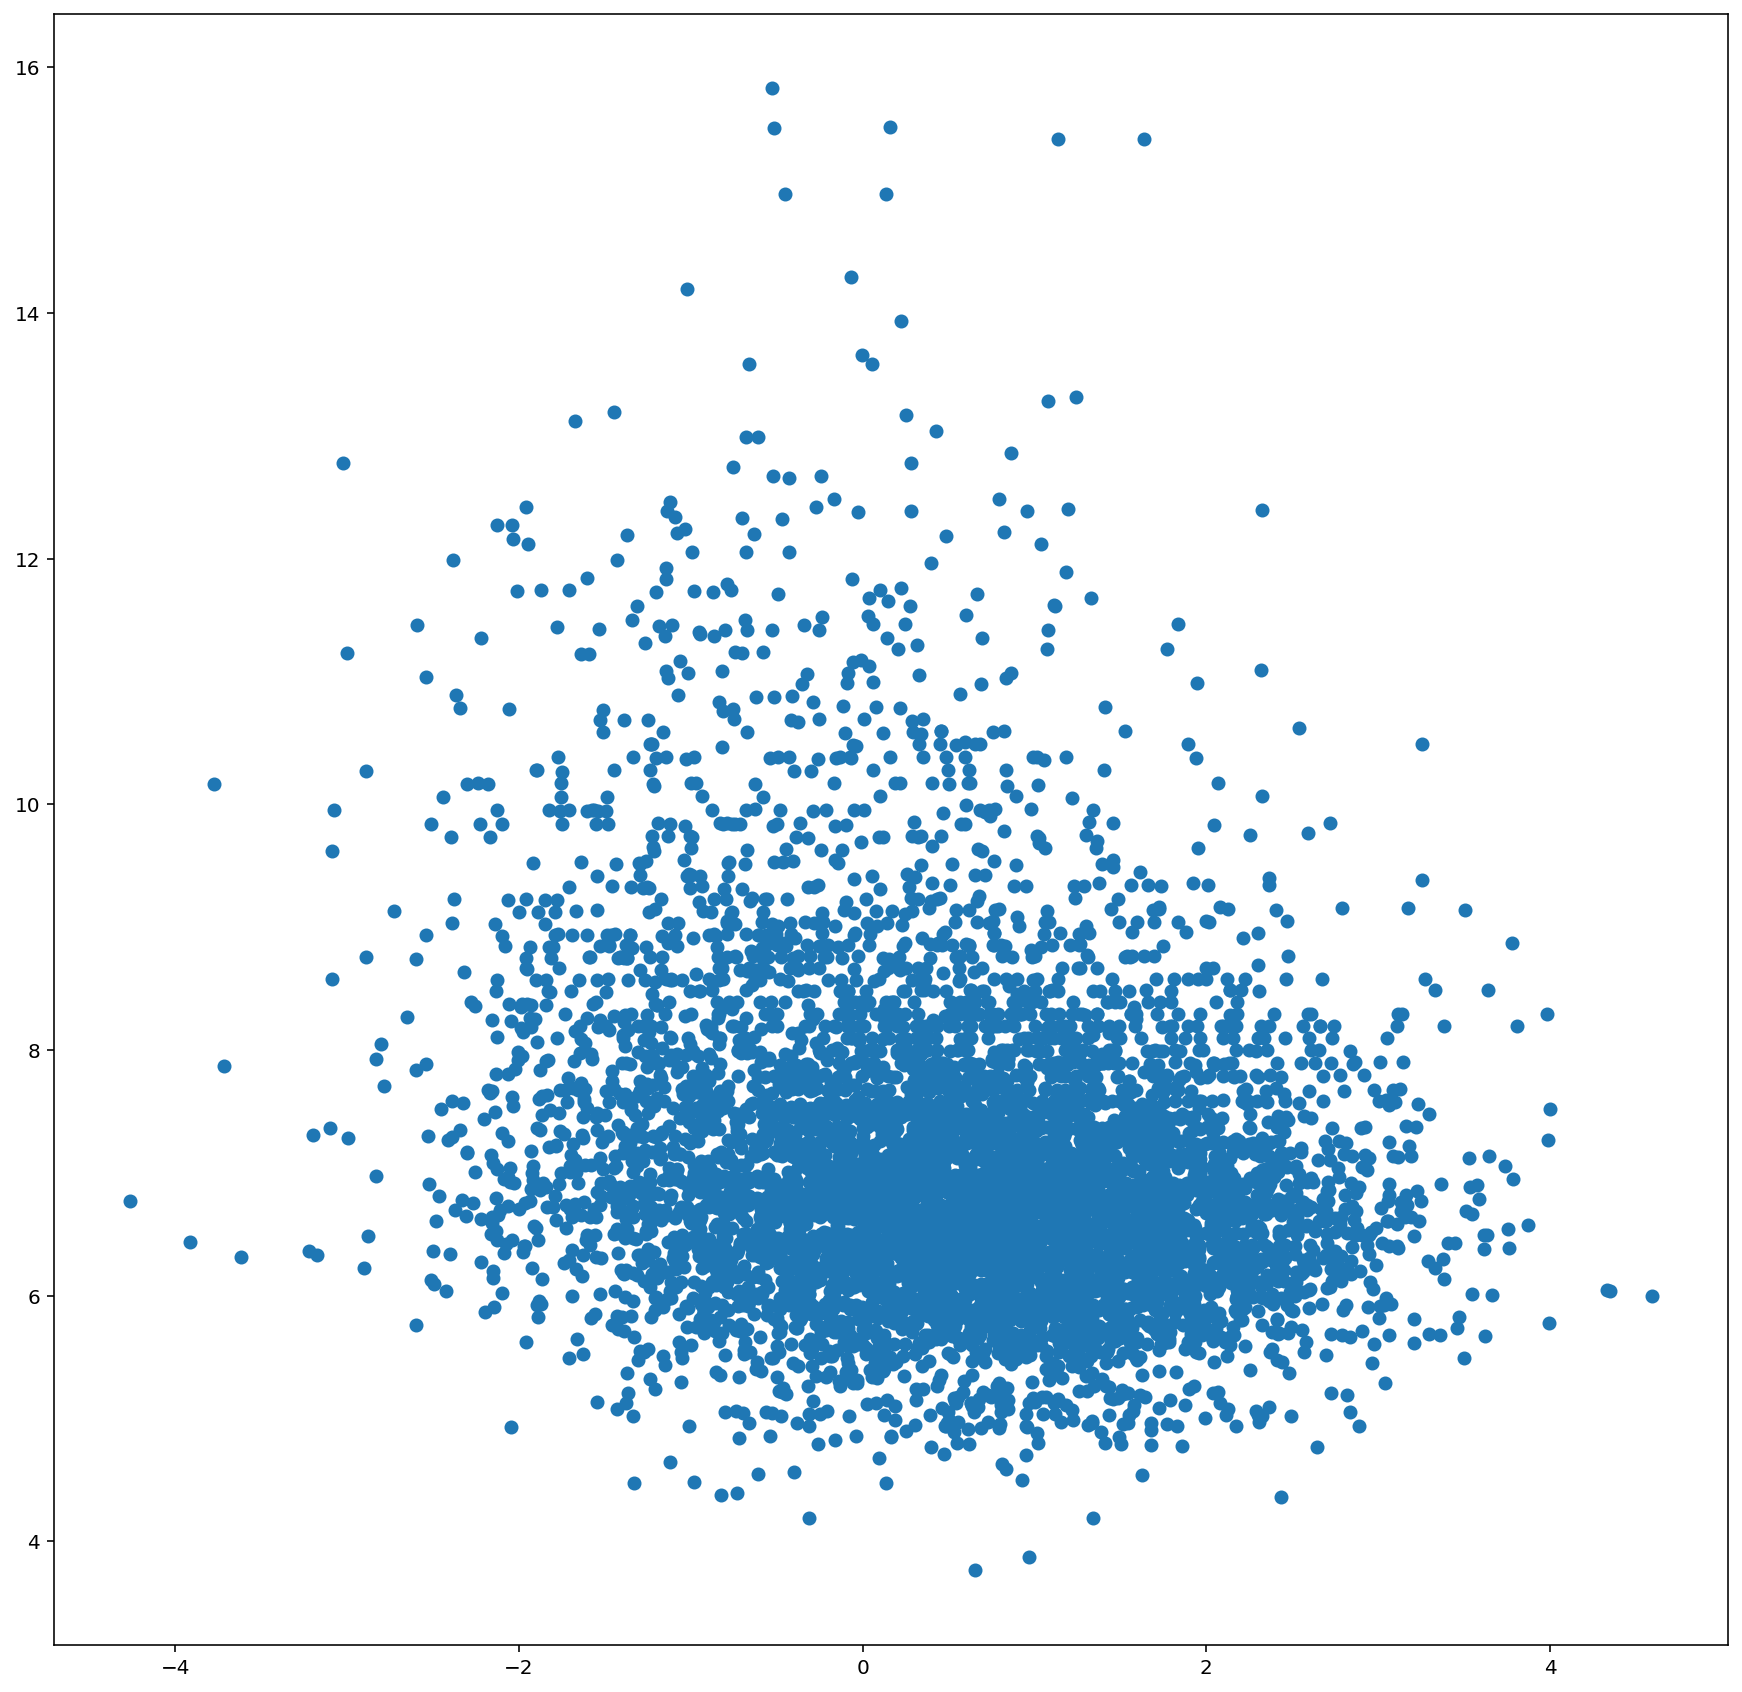

In [62]:
plt.figure(figsize=(15,15))
plt.plot(x1, y1, 'o')

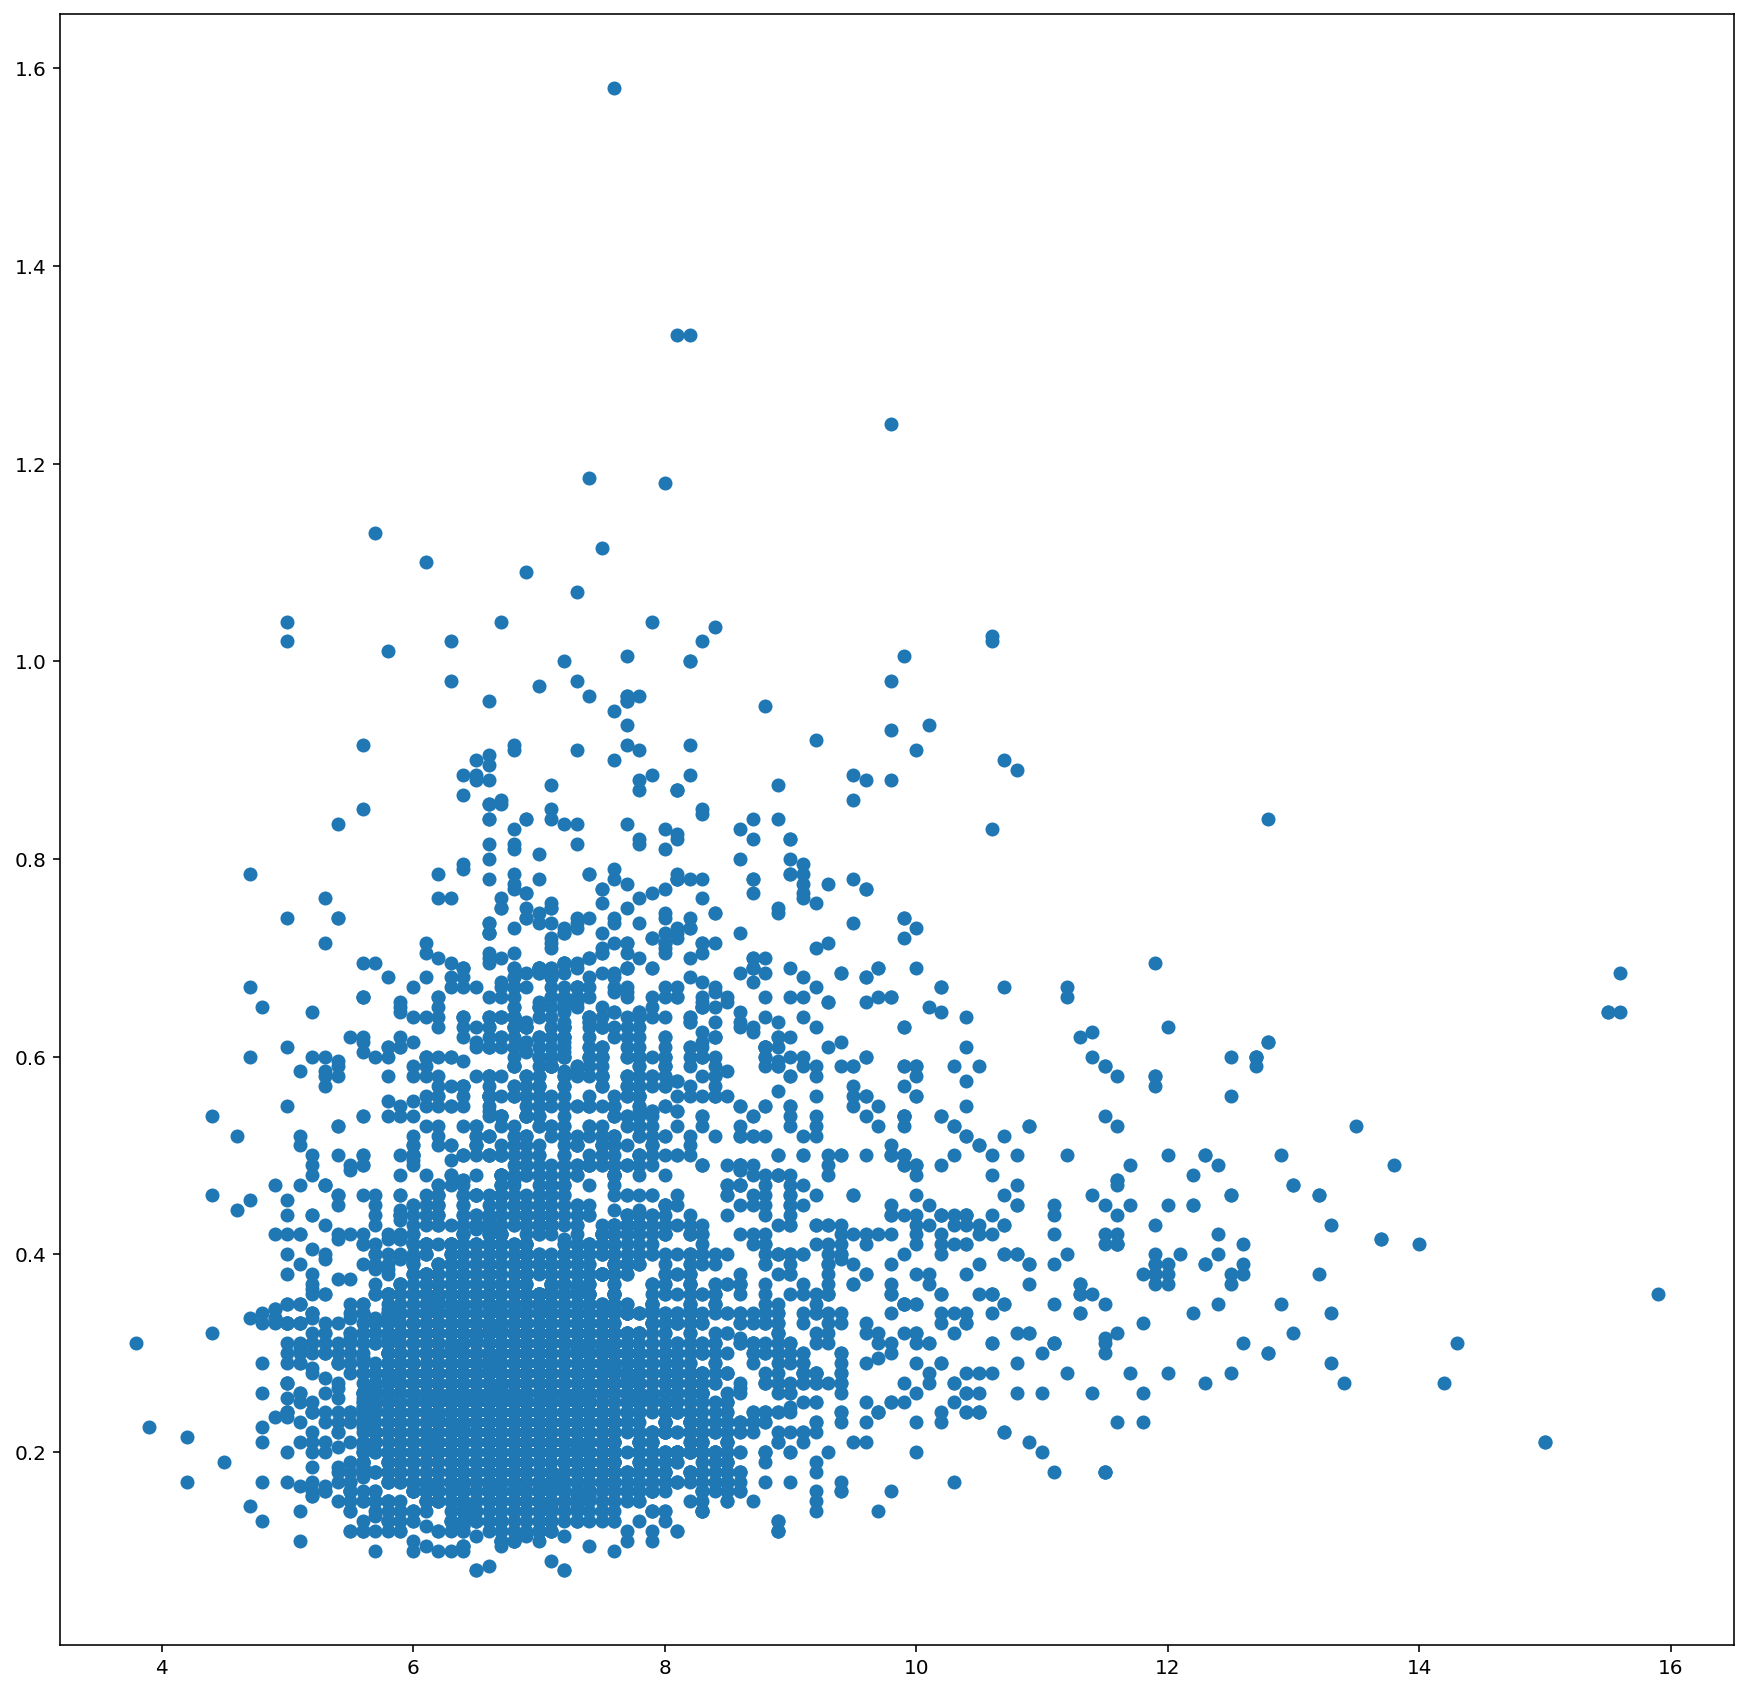

In [12]:
plt.figure(figsize=(15,15))
plt.plot(x, y, 'o')

In [68]:
lb = np.array([0] * n_column)
ub = np.array(column_interval_number) - 1
lhs_sample = lb + (ub - lb) * lhs(n_column, samples=args.lhs_n, criterion='center')
index = np.round(lhs_sample).astype(np.int32)
grid_mesh = np.empty_like(index, dtype=np.float32)
for i in range(args.lhs_n):
    idx = index[i, :]
    grid_mesh[i] = [unique_intervals[j][idx[j]] for j in range(n_column)]
sample_df = pd.DataFrame(grid_mesh, columns=[f'col_{i}' for i in range(n_column)])
grid_a = np.array(sample_df.sort_values(by=list(sample_df.columns)))
greatest = np.array([v[-1] for v in unique_intervals.values()]).reshape(1, -1)
grid = np.concatenate([grid_a, greatest], axis=0)
# transform 1-input grid to 2-input extend grid
assert grid.shape[1] == n_column
length = grid.shape[0]
inf = [0] * length
grid_dict = {}
for i in range(n_column):
    grid_dict[f'col_{i}_inf'] = inf
    grid_dict[f'col_{i}_sup'] = grid[:, i]
extend_grid = np.array(pd.DataFrame(grid_dict))
print("Begin model inference")
pred = m.inference(extend_grid)
print("Done")

#pred = pred[0]
newpred = np.round(pred * n_row)  # newpred is the predict cardinality
print("\nBegin generating table...")
dataNew = generate_data_new(grid, newpred)

print("\nFinish generate table, calculating Q-error on new table...")
time4 = time.time()
diff = execute_query(dataNew, query_set)
print_error(diff, args)

print(f"\noriginal table shape: {table_size}")
print(f"  Our table shape   : {dataNew.shape}")
time5 = time.time()

print("\nTime passed:")
print(" Generate Query  :  ", calc_time(time0, time1))
print(" Build  Lattice  :  ", calc_time(time1, time2))
print("   Training      :  ", calc_time(time2, time3))
print("Generate New Data:  ", calc_time(time3, time4))
print("Calculate Q-error:  ", calc_time(time4, time5))

Begin model inference
Done

Begin generating table...




Finish generate table, calculating Q-error on new table...





 Q-error of Lattice (query size=10000, condition=1, epoches=5000):

min:    1.0
10:     1.0012330456226881
20:     1.0021929824561404
30:     1.0051224587802146
40:     1.008038854463239
median: 1.013973936253729
60:     1.0179222839016653
70:     1.0559951308581863
80:     1.2551440329218106
90:     1.8
95:     2.25
max:    18.0
mean:   1.414276521962746

original table shape: (6497, 1)
  Our table shape   : (6497, 1)

Time passed:
 Generate Query  :   00:00:08
 Build  Lattice  :   00:00:00
   Training      :   00:00:03
Generate New Data:   00:00:45
Calculate Q-error:   00:00:17


In [75]:
# Full-Factorial net of unique intervals
values = [v for v in unique_intervals.values()]
mesh = np.meshgrid(*values)
grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)
# transform 1-input grid to 2-input extend grid
assert grid.shape[1] == n_column
length = grid.shape[0]
inf = [0] * length
grid_dict = {}
for i in range(n_column):
    grid_dict[f'col_{i}_inf'] = inf
    grid_dict[f'col_{i}_sup'] = grid[:, i]
extend_grid = np.array(pd.DataFrame(grid_dict))
print("Begin model inference")
pred = m.inference(extend_grid)
print("Done")

#pred = pred[0]
newpred = np.round(pred * n_row)  # newpred is the predict cardinality
print("\nBegin generating table...")
dataNew = generate_data_new(grid, newpred)

print("\nFinish generate table, calculating Q-error on new table...")
time4 = time.time()
diff = execute_query(dataNew, query_set)
print_error(diff, args)

print(f"\noriginal table shape: {table_size}")
print(f"  Our table shape   : {dataNew.shape}")
time5 = time.time()

print("\nTime passed:")
print(" Generate Query  :  ", calc_time(time0, time1))
print(" Build  Lattice  :  ", calc_time(time1, time2))
print("   Training      :  ", calc_time(time2, time3))
print("Generate New Data:  ", calc_time(time3, time4))
print("Calculate Q-error:  ", calc_time(time4, time5))

Begin model inference
Done

Begin generating table...




Finish generate table, calculating Q-error on new table...





 Q-error of Lattice (query size=10000, condition=1, epoches=5000):

min:    1.0
10:     1.0004779353194202
20:     1.000924499229584
30:     1.0013876040703054
40:     1.001851280468991
median: 1.002611490558457
60:     1.0055128633478116
70:     1.020816214735689
80:     1.0832432432432433
90:     1.2188385269121813
95:     2.0
max:    14.0
mean:   1.2570915634149082

original table shape: (6497, 1)
  Our table shape   : (6496, 1)

Time passed:
 Generate Query  :   00:00:08
 Build  Lattice  :   00:00:00
   Training      :   00:00:04
Generate New Data:   00:00:22
Calculate Q-error:   00:00:17


In [76]:
dataNew

,col_0
0,1.9
1,1.9
2,1.9
3,1.9
4,1.9
...,...
6491,13.2
6492,13.2
6493,13.2
6494,13.3


In [77]:
grid

array([[ 0.  ],
       [ 1.9 ],
       [ 3.8 ],
       [ 3.9 ],
       [ 4.2 ],
       [ 4.4 ],
       [ 4.5 ],
       [ 4.6 ],
       [ 4.7 ],
       [ 4.8 ],
       [ 4.9 ],
       [ 5.  ],
       [ 5.1 ],
       [ 5.2 ],
       [ 5.3 ],
       [ 5.4 ],
       [ 5.5 ],
       [ 5.6 ],
       [ 5.7 ],
       [ 5.8 ],
       [ 5.9 ],
       [ 6.  ],
       [ 6.1 ],
       [ 6.15],
       [ 6.2 ],
       [ 6.3 ],
       [ 6.4 ],
       [ 6.45],
       [ 6.5 ],
       [ 6.6 ],
       [ 6.7 ],
       [ 6.8 ],
       [ 6.9 ],
       [ 7.  ],
       [ 7.1 ],
       [ 7.15],
       [ 7.2 ],
       [ 7.3 ],
       [ 7.4 ],
       [ 7.5 ],
       [ 7.6 ],
       [ 7.7 ],
       [ 7.8 ],
       [ 7.9 ],
       [ 8.  ],
       [ 8.1 ],
       [ 8.2 ],
       [ 8.3 ],
       [ 8.4 ],
       [ 8.5 ],
       [ 8.6 ],
       [ 8.7 ],
       [ 8.8 ],
       [ 8.9 ],
       [ 9.  ],
       [ 9.1 ],
       [ 9.2 ],
       [ 9.3 ],
       [ 9.4 ],
       [ 9.5 ],
       [ 9.6 ],
       [ 9.7 ],
       [

In [88]:
m.inference(extend_grid)*n_row

array([[   0.    ],
       [   0.    ],
       [   0.    ],
       ...,
       [6494.5317],
       [6496.727 ],
       [6496.727 ]], dtype=float32)

In [87]:
sort_train_X

array([[ 0.  ,  3.8 ],
       [ 0.  ,  3.9 ],
       [ 0.  ,  4.2 ],
       [ 0.  ,  4.4 ],
       [ 0.  ,  4.5 ],
       [ 0.  ,  4.6 ],
       [ 0.  ,  4.7 ],
       [ 0.  ,  4.8 ],
       [ 0.  ,  4.9 ],
       [ 0.  ,  5.  ],
       [ 0.  ,  5.1 ],
       [ 0.  ,  5.2 ],
       [ 0.  ,  5.3 ],
       [ 0.  ,  5.4 ],
       [ 0.  ,  5.5 ],
       [ 0.  ,  5.6 ],
       [ 0.  ,  5.7 ],
       [ 0.  ,  5.8 ],
       [ 0.  ,  5.9 ],
       [ 0.  ,  6.  ],
       [ 0.  ,  6.1 ],
       [ 0.  ,  6.15],
       [ 0.  ,  6.2 ],
       [ 0.  ,  6.3 ],
       [ 0.  ,  6.4 ],
       [ 0.  ,  6.45],
       [ 0.  ,  6.5 ],
       [ 0.  ,  6.6 ],
       [ 0.  ,  6.7 ],
       [ 0.  ,  6.8 ],
       [ 0.  ,  6.9 ],
       [ 0.  ,  7.  ],
       [ 0.  ,  7.1 ],
       [ 0.  ,  7.15],
       [ 0.  ,  7.2 ],
       [ 0.  ,  7.3 ],
       [ 0.  ,  7.4 ],
       [ 0.  ,  7.5 ],
       [ 0.  ,  7.6 ],
       [ 0.  ,  7.7 ],
       [ 0.  ,  7.8 ],
       [ 0.  ,  7.9 ],
       [ 0.  ,  8.  ],
       [ 0.

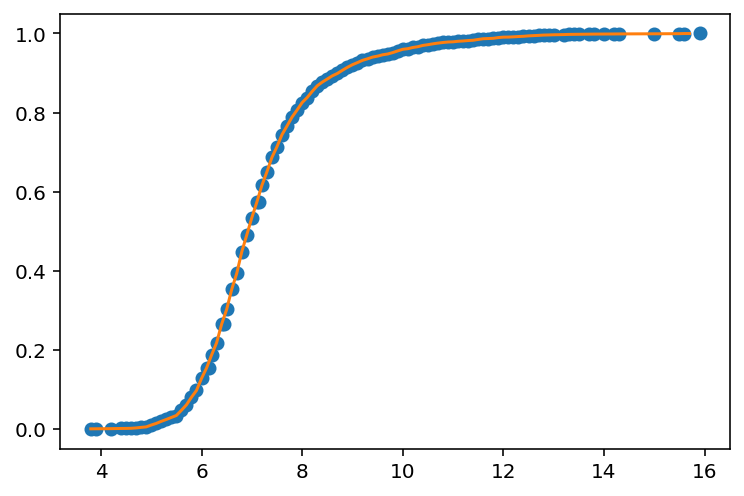

In [98]:
import matplotlib.pyplot as plt
from scipy import interpolate
x = sort_train_X[:, 1]
y = sort_train_Y.ravel()
f = interpolate.interp1d(x, y)

xnew = np.arange(3.8, 15.8, 0.1)
ynew = f(xnew)
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

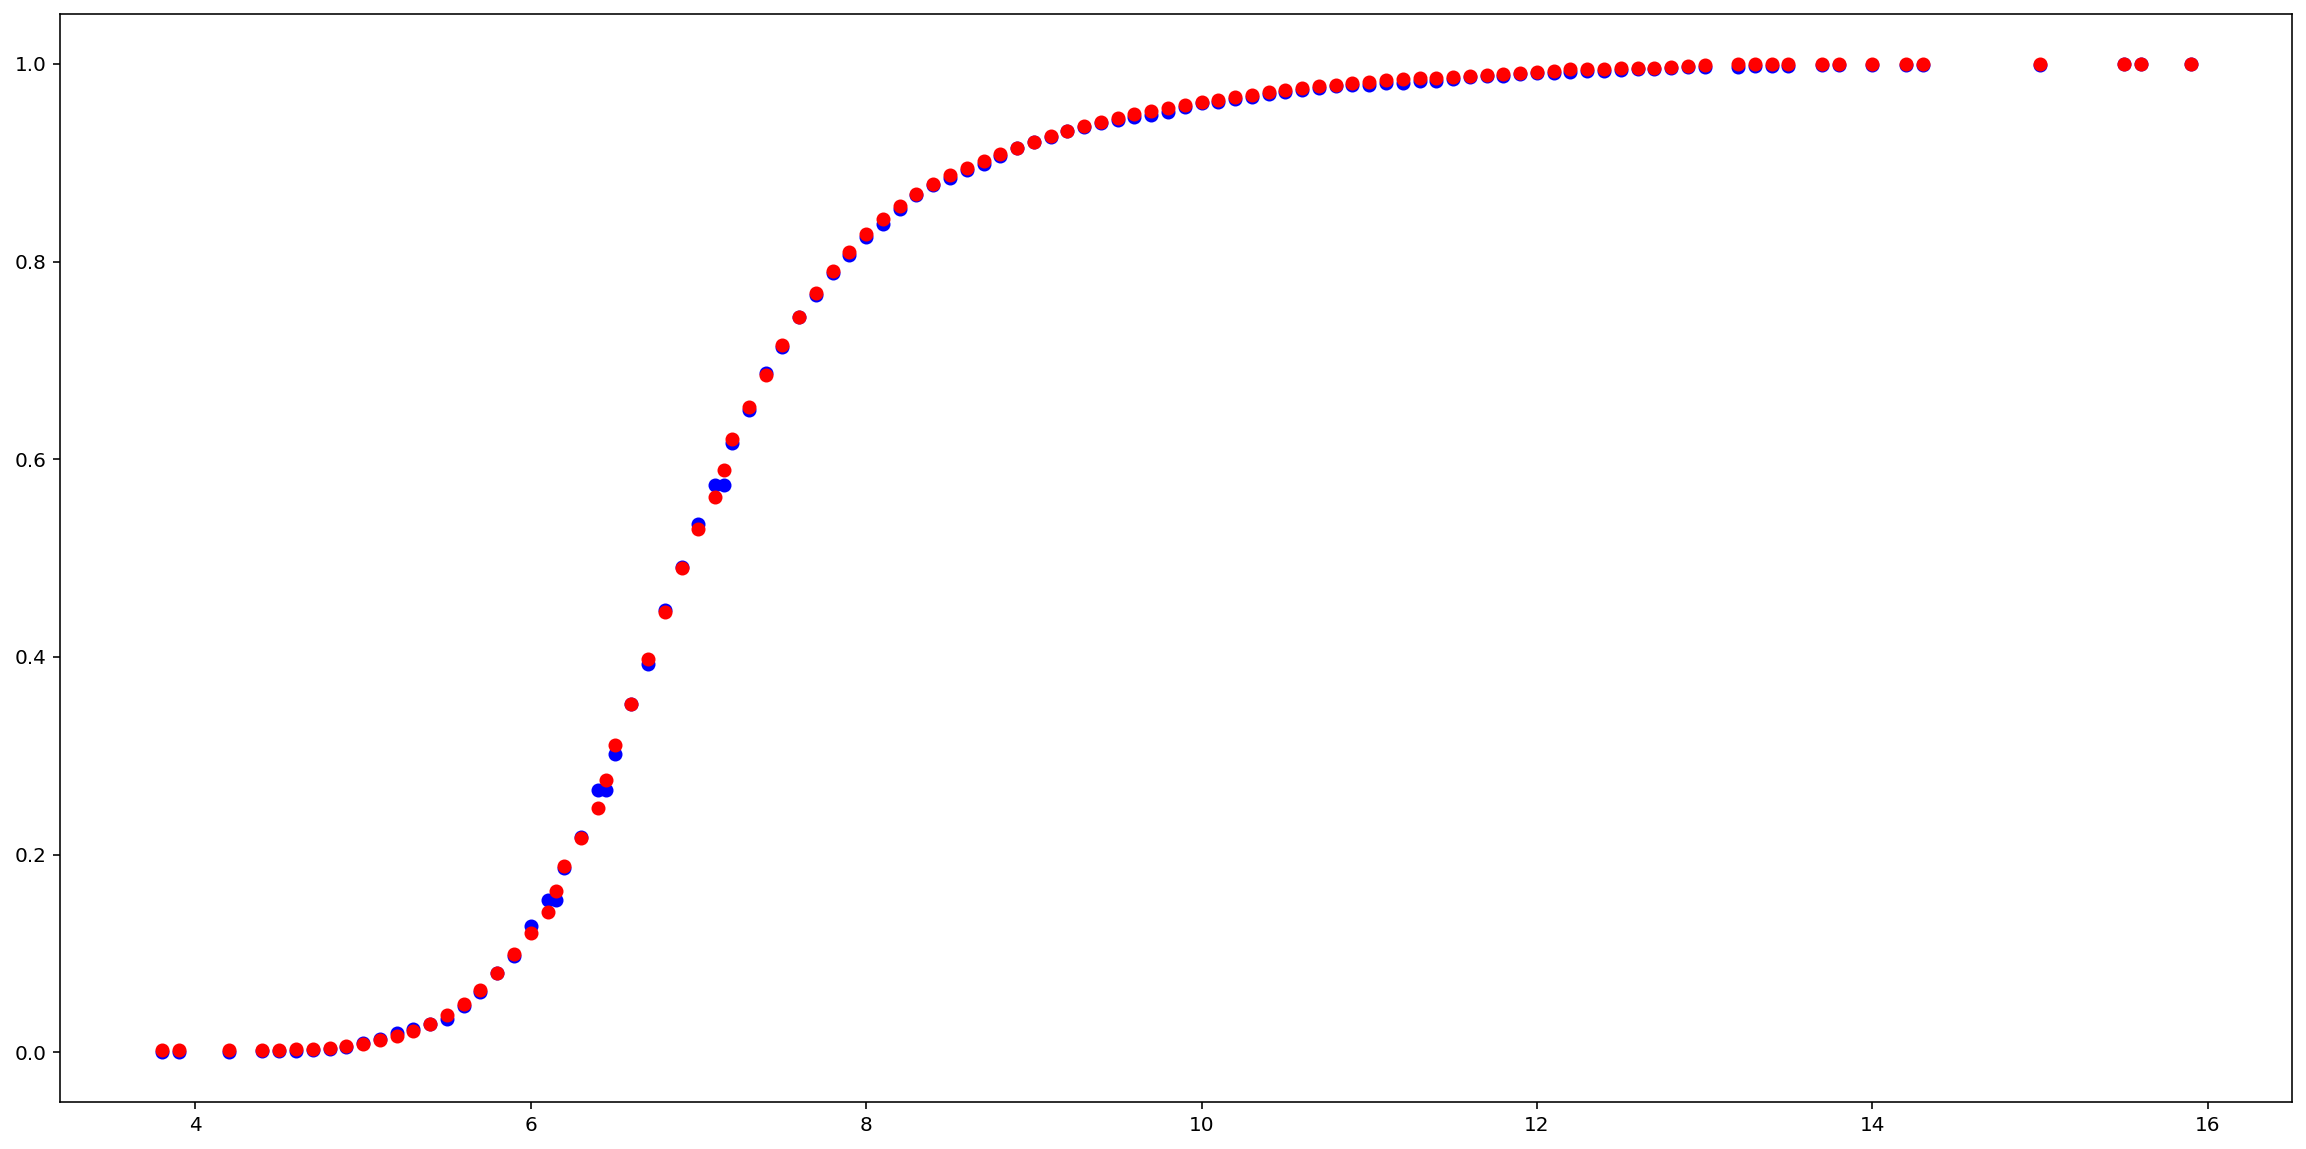

In [78]:
# 三层 pwl + 合适的 key points  + lattice
plt.figure(figsize=(20, 10))
plt.plot(sort_train_X[:, 1], sort_train_Y, 'bo')
plt.plot(sort_train_X[:, 1], m.inference(sort_train_X), 'ro')

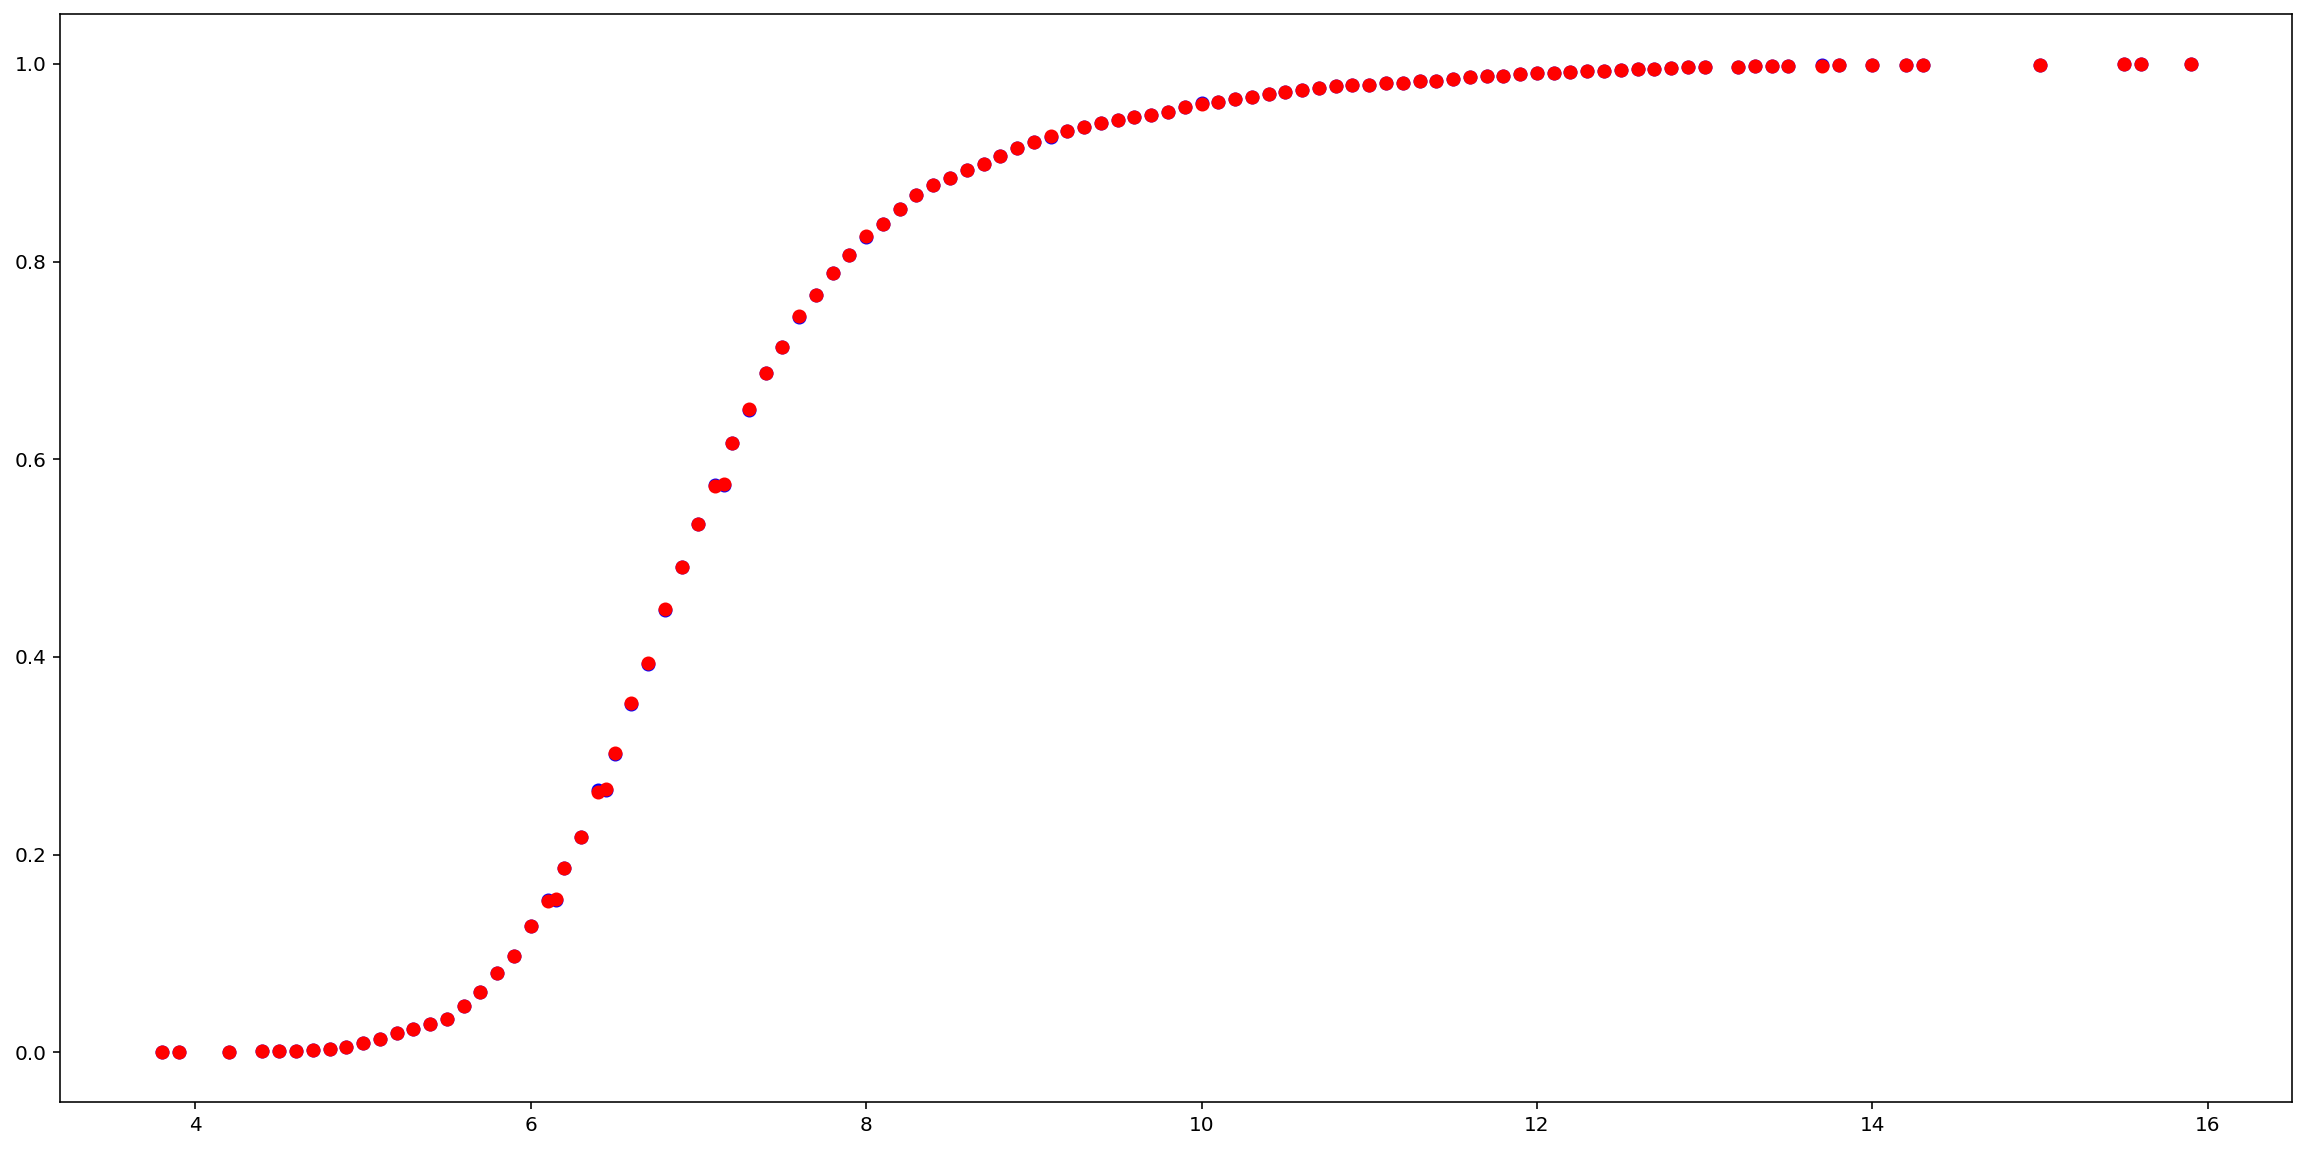

In [60]:
# 三层 pwl + 合适的 key points 拟合效果还是不错的
plt.figure(figsize=(20, 10))
plt.plot(sort_train_X[:, 1], sort_train_Y, 'bo')
plt.plot(sort_train_X[:, 1], m.inference(sort_train_X), 'ro')

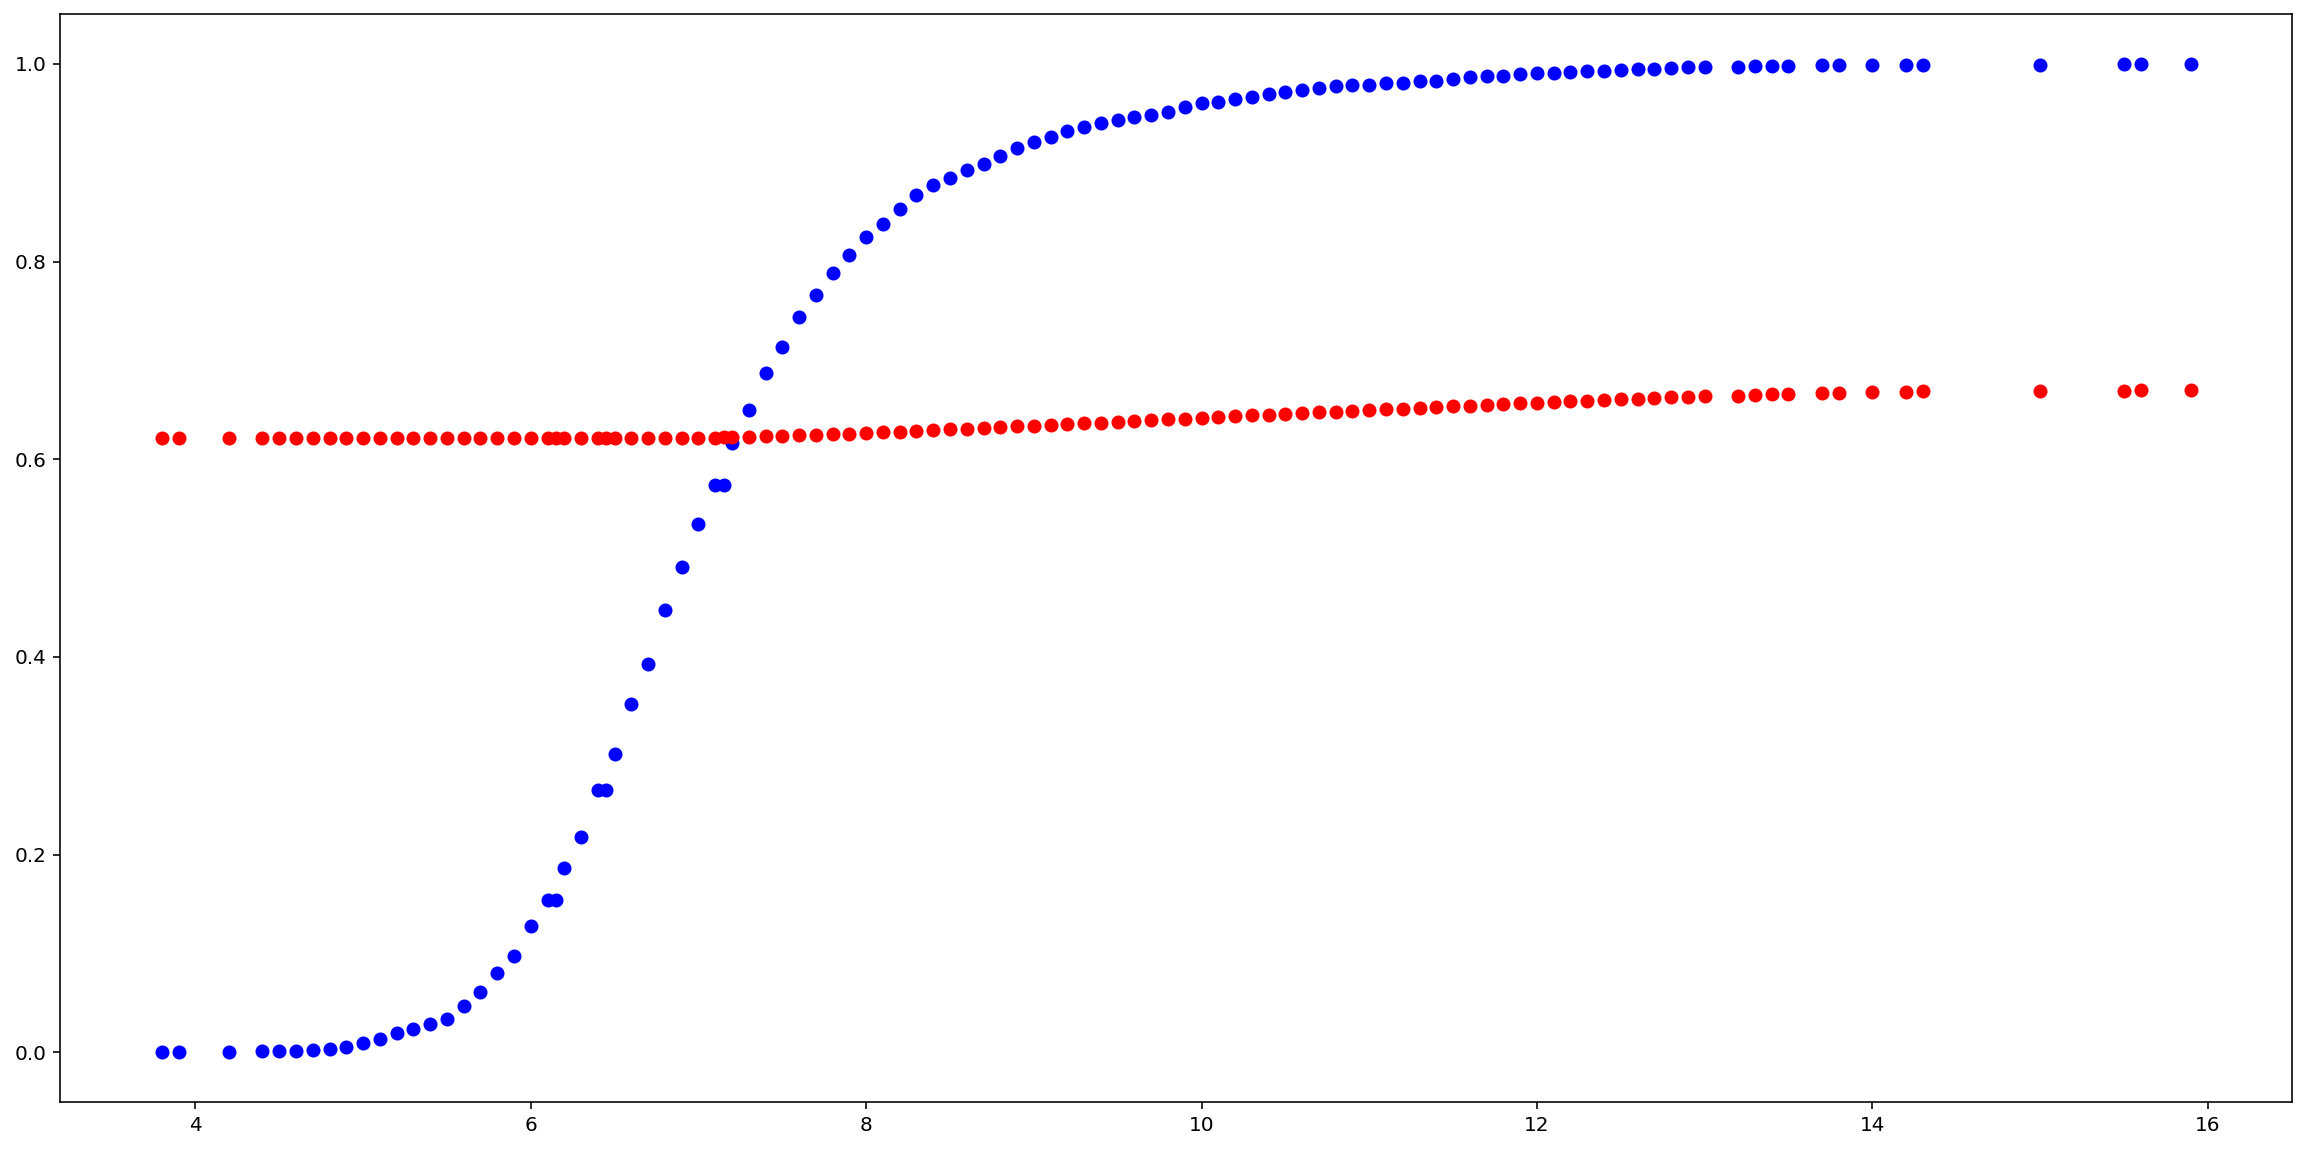

In [56]:
# 不同的key points 会影响模型的预测效果
plt.figure(figsize=(20, 10))
plt.plot(sort_train_X[:, 1], sort_train_Y, 'bo')
plt.plot(sort_train_X[:, 1], m.inference(sort_train_X), 'ro')

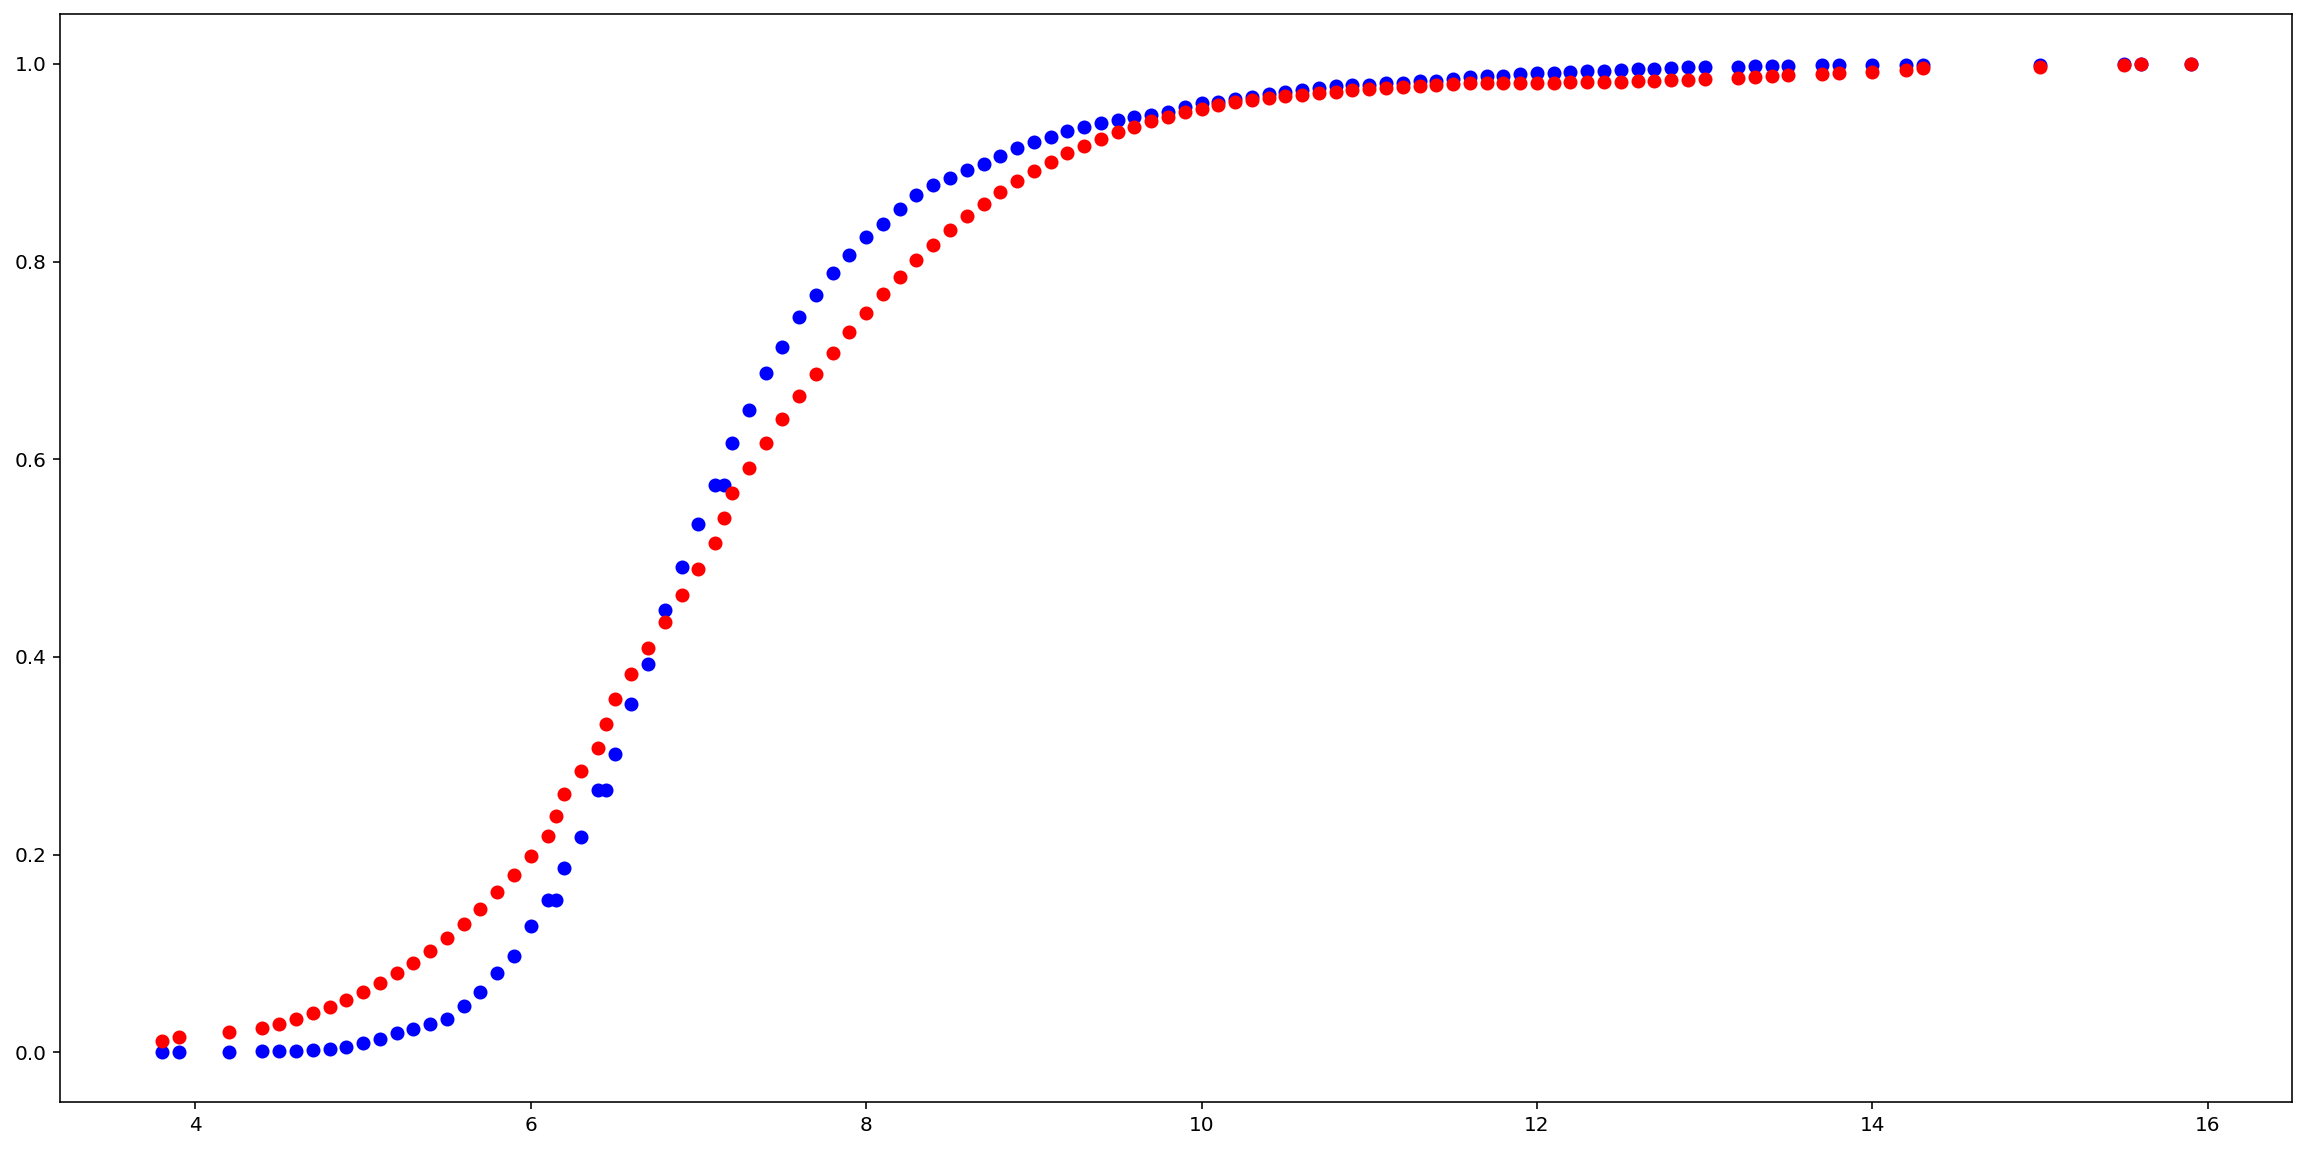

In [45]:
plt.figure(figsize=(20, 10))
plt.plot(sort_train_X[:, 1], sort_train_Y, 'bo')
plt.plot(sort_train_X[:, 1], m.inference(sort_train_X), 'ro')

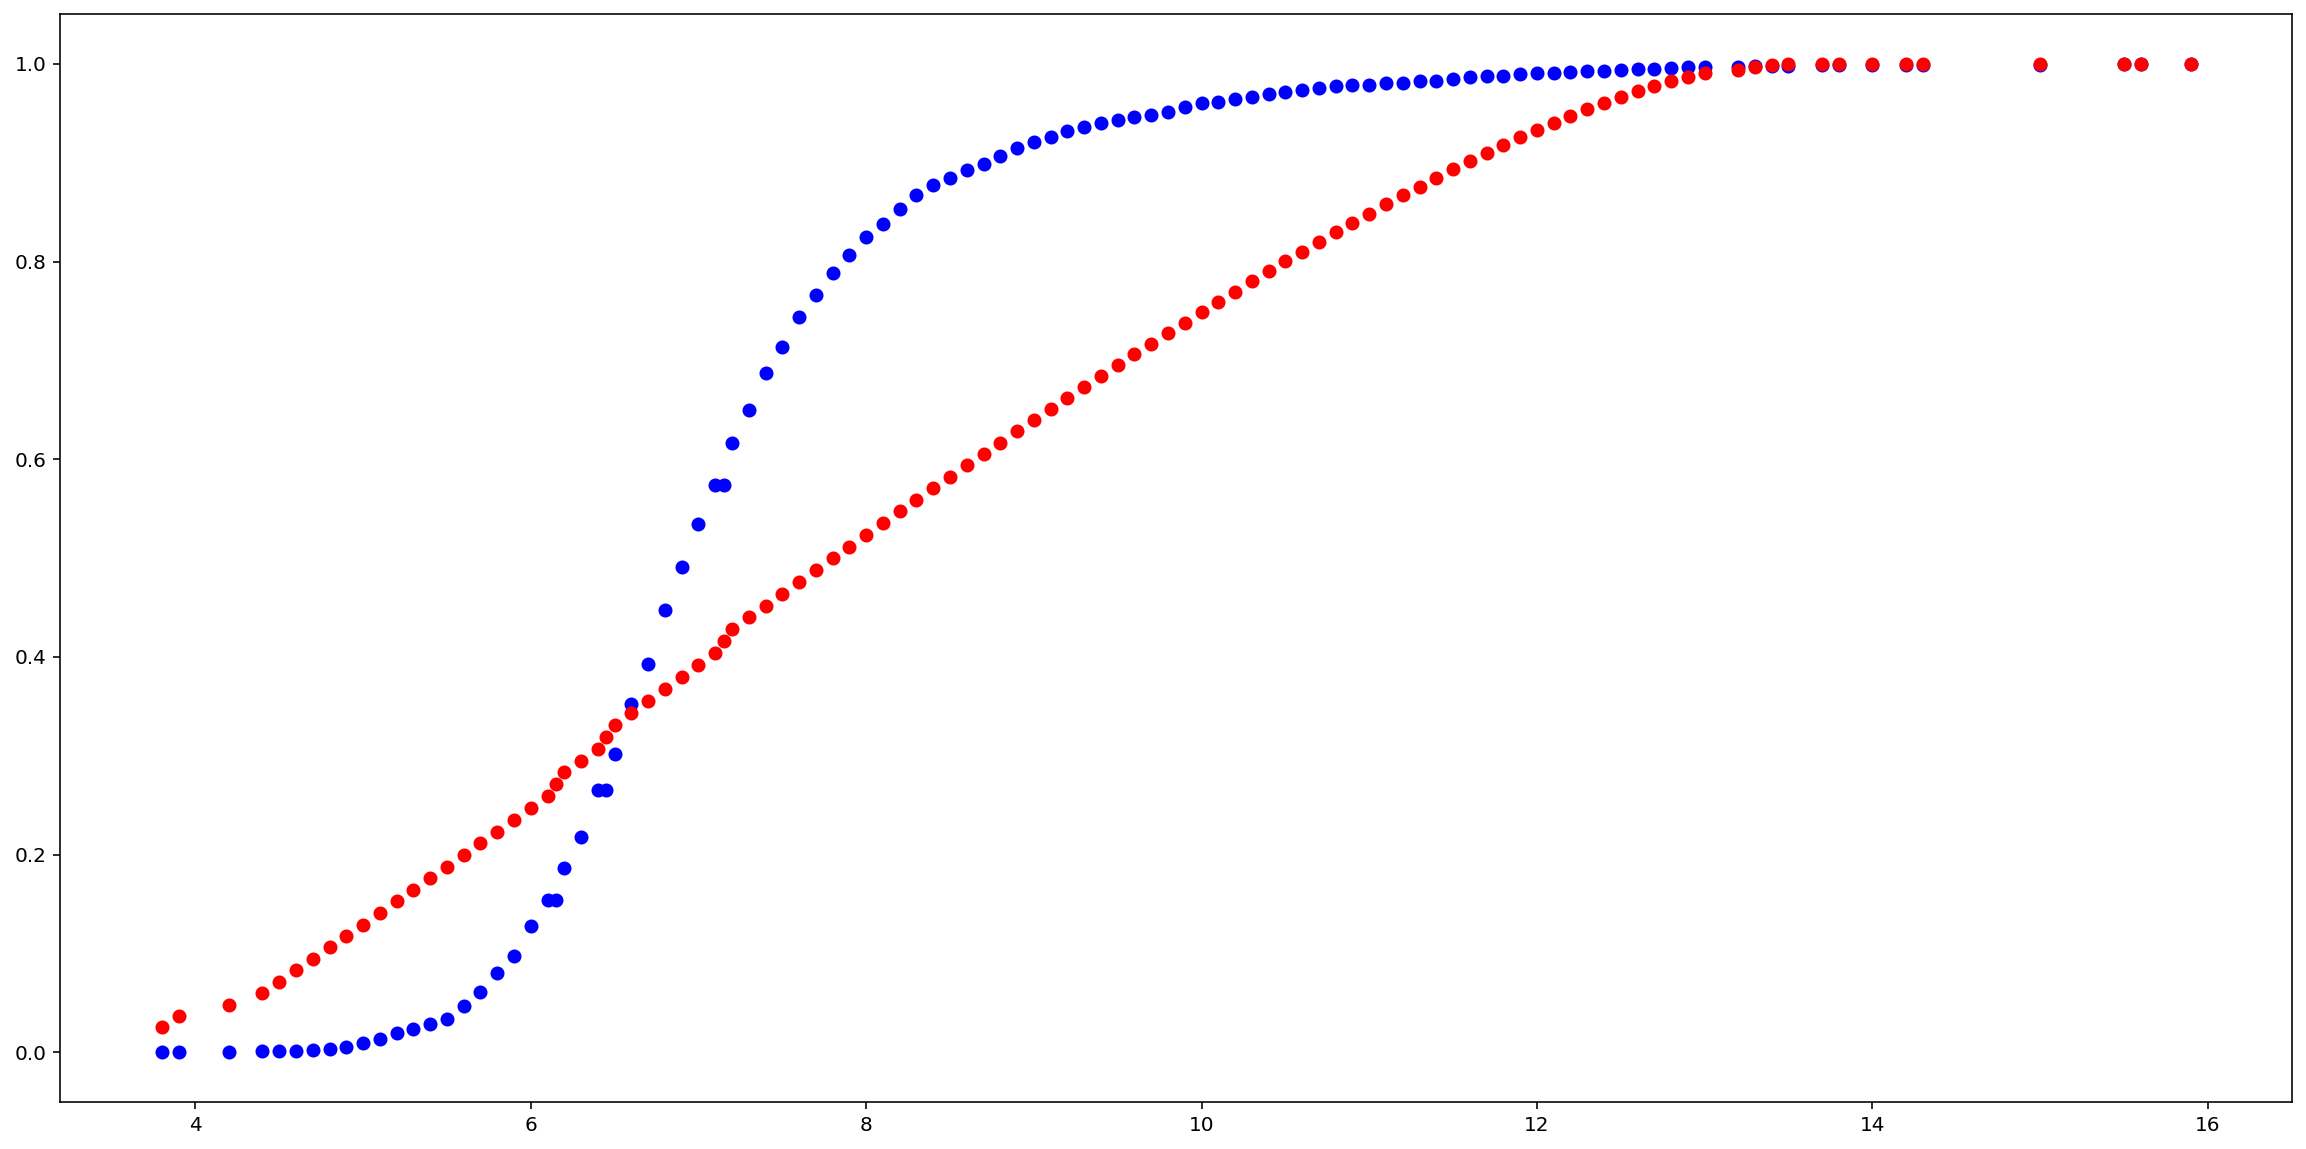

In [43]:
# epochs = 50, 1000 query
plt.figure(figsize=(20, 10))
plt.plot(sort_train_X[:, 1], sort_train_Y, 'bo')
plt.plot(sort_train_X[:, 1], m.inference(sort_train_X), 'ro')

In [3]:
values = [v for v in unique_intervals.values()] * 2
mesh = np.meshgrid(*values)  # 所有unique interval 的笛卡尔积网格
grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)

In [4]:
grid

array([[ 0. ,  0. ],
       [ 0. ,  1.9],
       [ 0. ,  3.8],
       ...,
       [16.9, 15.6],
       [16.9, 15.9],
       [16.9, 16.9]], dtype=float32)

In [5]:
m.inference(np.array([[0,0]]))

array([[0.0507793]], dtype=float32)

In [6]:
m.inference(np.array([[0,14.7]]))

array([[0.9989679]], dtype=float32)

In [7]:
m.inference(np.array([[2,14.7]]))

array([[0.9989679]], dtype=float32)

In [8]:
m.inference(np.array([[2,1]]))

array([[0.0502167]], dtype=float32)

In [9]:
train_X

array([[ 0. ,  3.8],
       [ 0. ,  4.2],
       [ 0. ,  4.2],
       ...,
       [ 0. , 15.6],
       [ 0. , 15.9],
       [ 0. , 15.9]], dtype=float32)

In [10]:
train_Y

array([[1.539172e-04],
       [6.156688e-04],
       [6.156688e-04],
       ...,
       [9.998461e-01],
       [1.000000e+00],
       [1.000000e+00]], dtype=float32)

In [11]:
pred = m.inference(grid)
#m.plotting(grid, pred)

In [12]:
# 增加边界点，看看对比的效果
# 增加epoch，看看误差和图形效果
# 增加query size，看看误差和效果

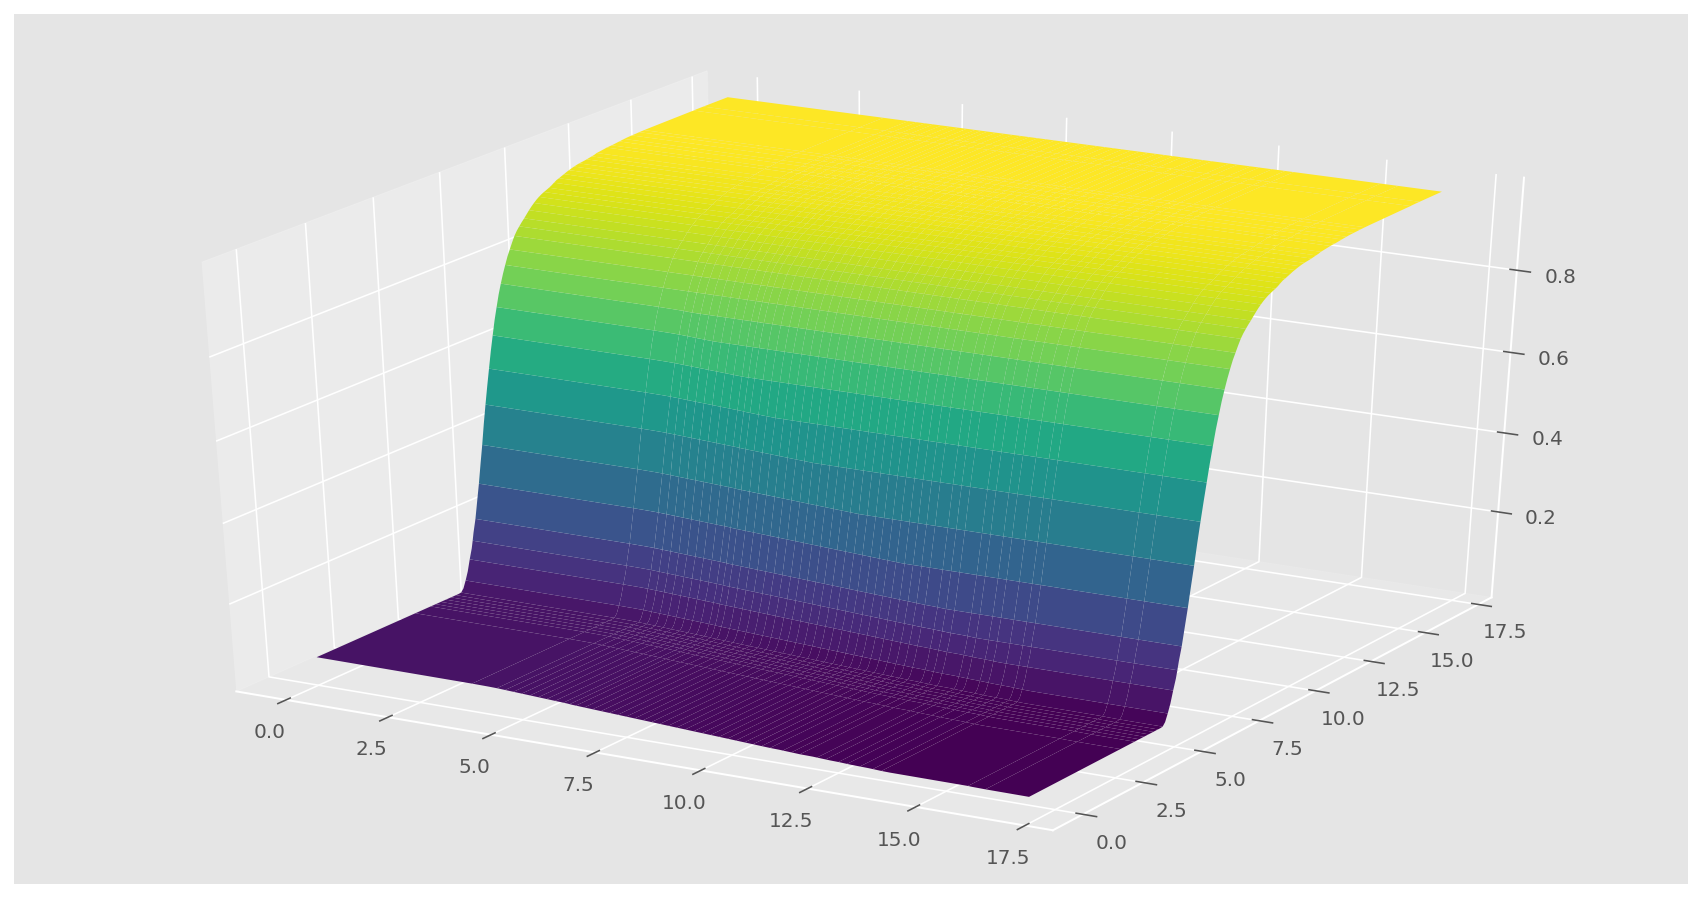

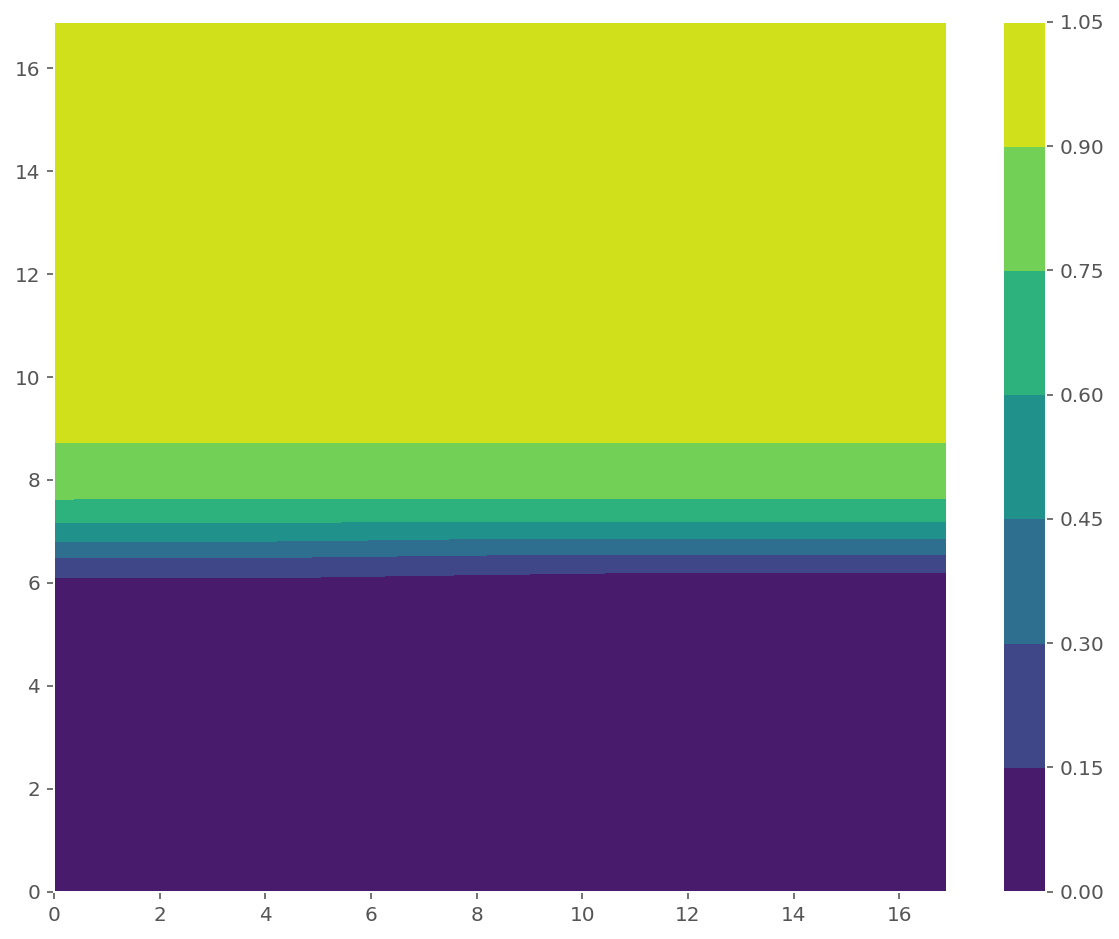

In [13]:
Xshape = len(np.unique(grid[:, 0]))
Yshape = len(np.unique(grid[:, 1]))
X = grid[:, 0].reshape(Xshape, Yshape)
Y = grid[:, 1].reshape(Xshape, Yshape)
Z = pred.reshape(Xshape, Yshape)

fig1 = plt.figure(figsize=(15, 8))
ax1 = plt.axes(projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
plt.show()

fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111)
cs = ax2.contourf(X, Y, Z, cmap='viridis')
# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())    # ??
cbar = fig2.colorbar(cs)  # 让colorbar细粒度更高一点
plt.show()